In [1]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import cProfile
import pstats
import pandas as pd
from datetime import datetime
import os
import ast

In [2]:
import os
import sys

path_common=os.path.dirname(os.path.abspath(''))+"/Common/";
sys.path.append(path_common) #Adds common path to import the python files

# Analysis of tuning of new neural networks


In [3]:
#Common folders
results_newNN_folder="../../results/NewNN/"
def get_present_experiments(text_to_have,folder):
    file_path_list=[];
    for dirpath, dnames, fnames in os.walk(folder):
        for f in fnames:
            if (text_to_have in f) and f.endswith("_log.txt"):
                file_path_list.append(folder+f);
    return file_path_list;

def get_runs_of_experiment(log_filepath,folder):
    common_start=os.path.basename(log_filepath)[:-8];
    df_final=None;
    for dirpath, dnames, fnames in os.walk(folder):
        for f in fnames:
            if (common_start in f) and f.endswith(".csv"):
                if df_final is None:
                    df_final=pd.read_csv(folder+f);
                else:
                    df = pd.read_csv(folder+f);
                    df_final=pd.concat([df_final, df]);
    return df_final

def get_param(filepath,param):
    param_text=param+":";
    retVal=None
    with open(filepath, 'r') as fp:
        line = fp.readline()
        while line != "": #File not finished
            if line.find(param_text)!= -1: #Text found
                str_2_convert=line[len(param)+2:]
                retVal=str_2_convert; #We want the string!
                #if param=="activation" or param=="Comment":
                ##    
                #else:
                #    retVal= 0 if ("None" in str_2_convert) else float(str_2_convert)
                break;
            line = fp.readline()
    return retVal;

def get_accs(df):
    all_accs=df.iloc[:,:3].to_numpy();
    all_means=np.mean(all_accs,axis=0);
    all_stds=np.std(all_accs,axis=0);
    all_maxs=np.max(all_accs,axis=0);
    train_mean=all_means[0];train_std=all_stds[0];train_max=all_maxs[0];
    valid_mean=all_means[1];valid_std=all_stds[1];valid_max=all_maxs[1];
    test_mean=all_means[2];test_std=all_stds[2];test_max=all_maxs[2];
    return train_mean,train_std,train_max,valid_mean,valid_std,valid_max,test_mean,test_std,test_max

In [4]:
def accs_stats_to_str(acc_mean,acc_std,acc_max):
    return '{:.2f}'.format(acc_mean*100) + "+-" +'{:.2f}'.format(acc_std*100) + "(" + '{:.2f}'.format(acc_max*100) +")"
def all_accs_stats_to_str(train_mean,train_std,train_max,valid_mean,valid_std,valid_max,test_mean,test_std,test_max):
    return [accs_stats_to_str(train_mean,train_std,train_max), accs_stats_to_str(valid_mean,valid_std,valid_max), accs_stats_to_str(test_mean,test_std,test_max)]

def string_loss_to_array(loss_str):
    return np.asarray(ast.literal_eval(loss_str.replace(" ", ",")));

def get_avg_losses(df):
    n_runs=len(df);n_epochs=len(string_loss_to_array(df.iloc[0,3]));
    indexes=[3,4,5];
    col_name=["Train","Valid","Train Aug"]
    mean_losses=[]; #To be generated
    std_losses=[]; #To be generated
    for i in range(len(indexes)):
        index_df=indexes[i];
        all_losses=np.zeros((n_runs,n_epochs))
        for j in range(n_runs):
            all_losses[j,:]=string_loss_to_array(df.iloc[j,index_df])
        mean_losses.append(np.mean(all_losses,axis=0))
        std_losses.append(np.std(all_losses,axis=0)/np.sqrt(n_runs))
    return mean_losses,std_losses
        
        

def compare_dfs(list_of_dfs,names,table_accs=True,plots=True):
    if table_accs:
        print("------------ Table comparison ----------------")
        list_table_accs=[]
        for i in range(len(list_of_dfs)):
            tm,ts,tM,vm,vs,vM,Tm,Ts,TM =get_accs(list_of_dfs[i])
            str_accs=all_accs_stats_to_str(tm,ts,tM,vm,vs,vM,Tm,Ts,TM)
            list_table_accs.append([names[i],str_accs[0],str_accs[1],str_accs[2],len(list_of_dfs[i])])
        df=pd.DataFrame(list_table_accs, columns=["Name","Train Accuracy","Valid Accuracy","Test Accuracy","nRuns"]);
        print(df);
        print("----------------------------------------------")
    if plots:
        print("------------ Plot comparison ----------------")
        n_plots=3; #Train, Valid, TrainAug losses
        f, axs = plt.subplots(n_plots, 1,figsize=(20,60))
        titles=["Train loss","Valid loss","Train aug loss"]
        for i in range(len(list_of_dfs)):
            mean_losses,std_losses=get_avg_losses(list_of_dfs[i]);
            n_epochs=len(mean_losses[0]);
            for j in range(n_plots):
                axs[j].errorbar(np.arange(n_epochs), mean_losses[j], yerr=std_losses[j]);
        
        for j in range(n_plots): 
            axs[j].set_title(titles[j])
            axs[j].legend(names)
            axs[j].set_ylim([0,2])
            axs[j].set_ylabel("Loss")
            axs[j].set_xlabel("Epoch")
            
def show_experiments_and_comments(results_folder):
    list_data=[];
    for dirpath, dnames, fnames in os.walk(results_folder):
        for f in fnames:
            if f.endswith("log.txt"):
                com=get_param(dirpath+"/"+f,"Comment")
                list_data.append([os.path.basename(dirpath),f,com])
    df=pd.DataFrame(list_data)
    return df;
def get_folder_and_filepath(res_folder,dir_name,file_name):
    dir_total=res_folder+dir_name+"/";
    return dir_total,dir_total+file_name;

def get_df(res_folder,dir_name,file_name):
    folder_path,file_path=get_folder_and_filepath(res_folder,dir_name,file_name)
    df=get_runs_of_experiment(file_path,folder_path)
    return df
def load_multiple_files(res_folder,dir_name,file_names):
    df_list=[];
    for fn in file_names:
        path_w_dir,file_path=get_folder_and_filepath(res_folder,dir_name,fn)
        df_list.append(get_runs_of_experiment(file_path,path_w_dir))
    df=pd.concat(df_list);
    return df;

In [5]:
df=show_experiments_and_comments(results_newNN_folder)
df

0                                            1  \
0   AttResQuipu                 20240418_13-57-44_LR_log.txt   
1          Test                 20240417_19-52-45_LR_log.txt   
2          Test                 20240417_16-24-15_LR_log.txt   
3    QuipuModif           20240419_15-18-53_QuipuRes_log.txt   
4    QuipuModif        20240421_21-17-38_QuipuAttRes_log.txt   
5         Quipu  20240421_19-49-01_QuipuExtBrowFinal_log.txt   
6         Quipu  20240419_15-28-23_QuipuExtBrowFinal_log.txt   
7         Quipu      20240419_15-28-23_QuipuExtFinal_log.txt   
8         Quipu        20240419_12-10-05_QuipuNoBrow_log.txt   
9         Quipu     20240419_12-11-14_QuipuFinalBrow_log.txt   
10        Quipu   20240419_12-12-25_QuipuFinalNoBrow_log.txt   
11        Quipu                 20240419_10-59-10_LR_log.txt   
12        Quipu      20240421_19-48-59_QuipuExtFinal_log.txt   
13        Quipu     20240421_19-50-42_QuipuFinalBrow_log.txt   

                                                    2  
0                                                None  
1                                                None  
2                                                None  
3              uipu but we add residual connections\n  
4              uipu but we add residual connections\n  
5            eproducing best quipuExt with brownian\n  
6            eproducing best quipuExt with brownian\n  
7         eproducing best quipuExt without brownian\n  
8   eproducing quipu in 50 epochs and with new set...  
9   eproducing quipu with new setup on the same te...  
10  eproducing quipu with new setup on the same te...  
11  eproducing quipu in 50 epochs and with new set...  
12        eproducing best quipuExt without brownian\n  
13              eproducing best quipu with brownian\n

------------ Table comparison ----------------
              Name      Train Accuracy      Valid Accuracy  \
0            Quipu  97.28+-0.38(97.97)  95.79+-0.36(96.45)   
1  Quipu (axis=-1)  96.95+-0.39(97.52)  95.36+-0.43(96.10)   

        Test Accuracy  nRuns  
0  95.76+-0.35(96.42)     27  
1  95.40+-0.44(96.02)     26  
----------------------------------------------
------------ Plot comparison ----------------


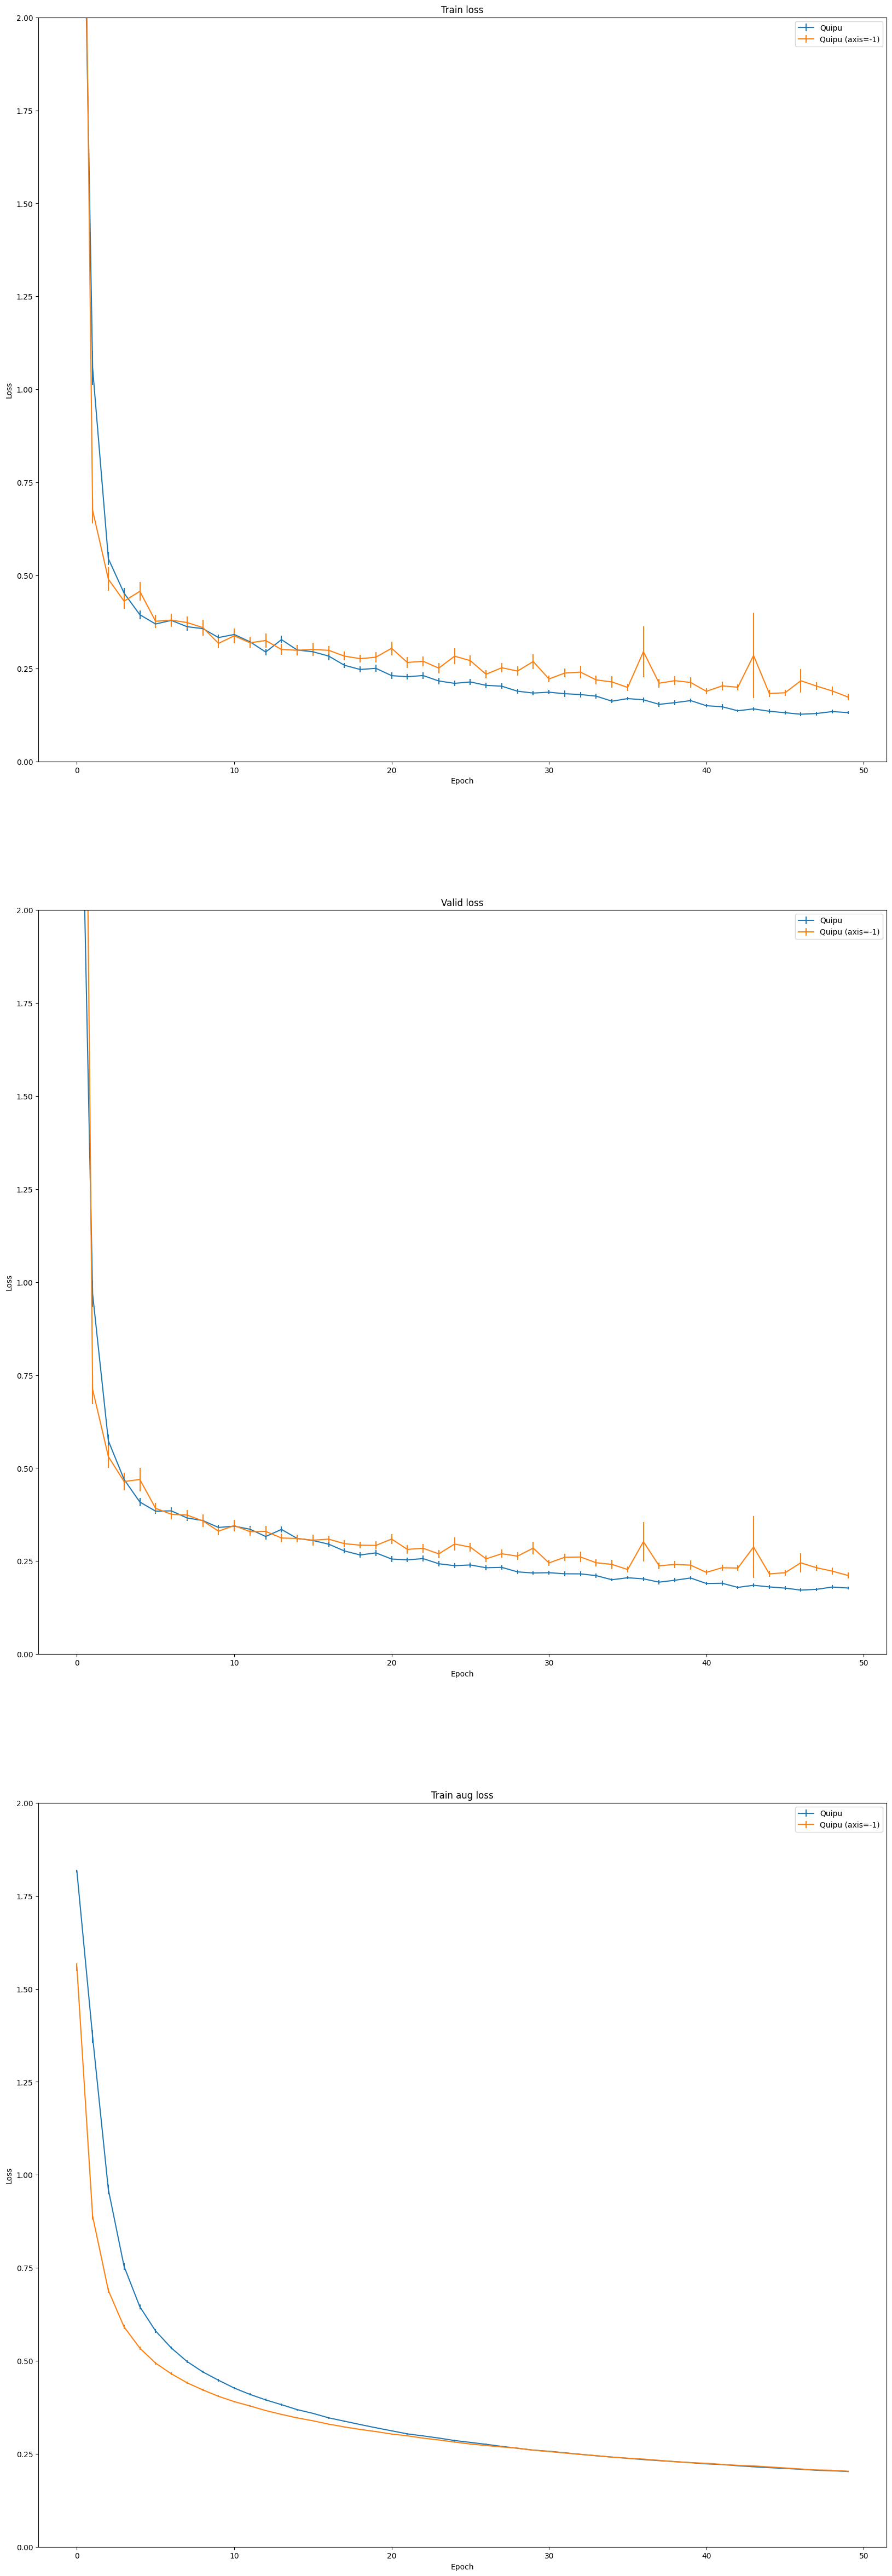

In [20]:
#Checking axis 
df_Quipu_axism1=get_df(results_newNN_folder,"Quipu","20240424_13-11-31_Quipu_log.txt") 
df_QuipuBrow=get_df(results_newNN_folder,"Quipu","20240419_10-59-10_LR_log.txt") 

compare_dfs([df_QuipuBrow,df_Quipu_axism1],["Quipu","Quipu (axis=-1)"])

## Comparing initial structures

### Attention residual 1D based on Resnet
Here we start first by running the Quipu architecture with our tuning training (which doesnt use data from the quipus test set), and also uses our optimized training. Our optimized training is with early stopping, augmentation techniques done in cupy to better use the GPU. Then we also run an architecture we proposed with attention and residual connections based on resnet for 1d. We then observe the results when training:

------------ Table comparison ----------------
                    Name      Train Accuracy      Valid Accuracy  \
0                  Quipu  98.07+-0.23(98.45)  96.17+-0.30(96.73)   
1              QuipuBrow  97.28+-0.38(97.97)  95.79+-0.36(96.45)   
2                    ARQ  96.85+-1.13(97.99)  95.01+-0.83(96.49)   
3  ARQ Dropout block 0.1  94.90+-1.14(96.69)  93.15+-1.34(95.13)   

        Test Accuracy  nRuns  
0  96.13+-0.30(96.88)     21  
1  95.76+-0.35(96.42)     27  
2  94.97+-0.82(96.06)     16  
3  93.29+-1.25(95.34)     20  
----------------------------------------------
------------ Plot comparison ----------------


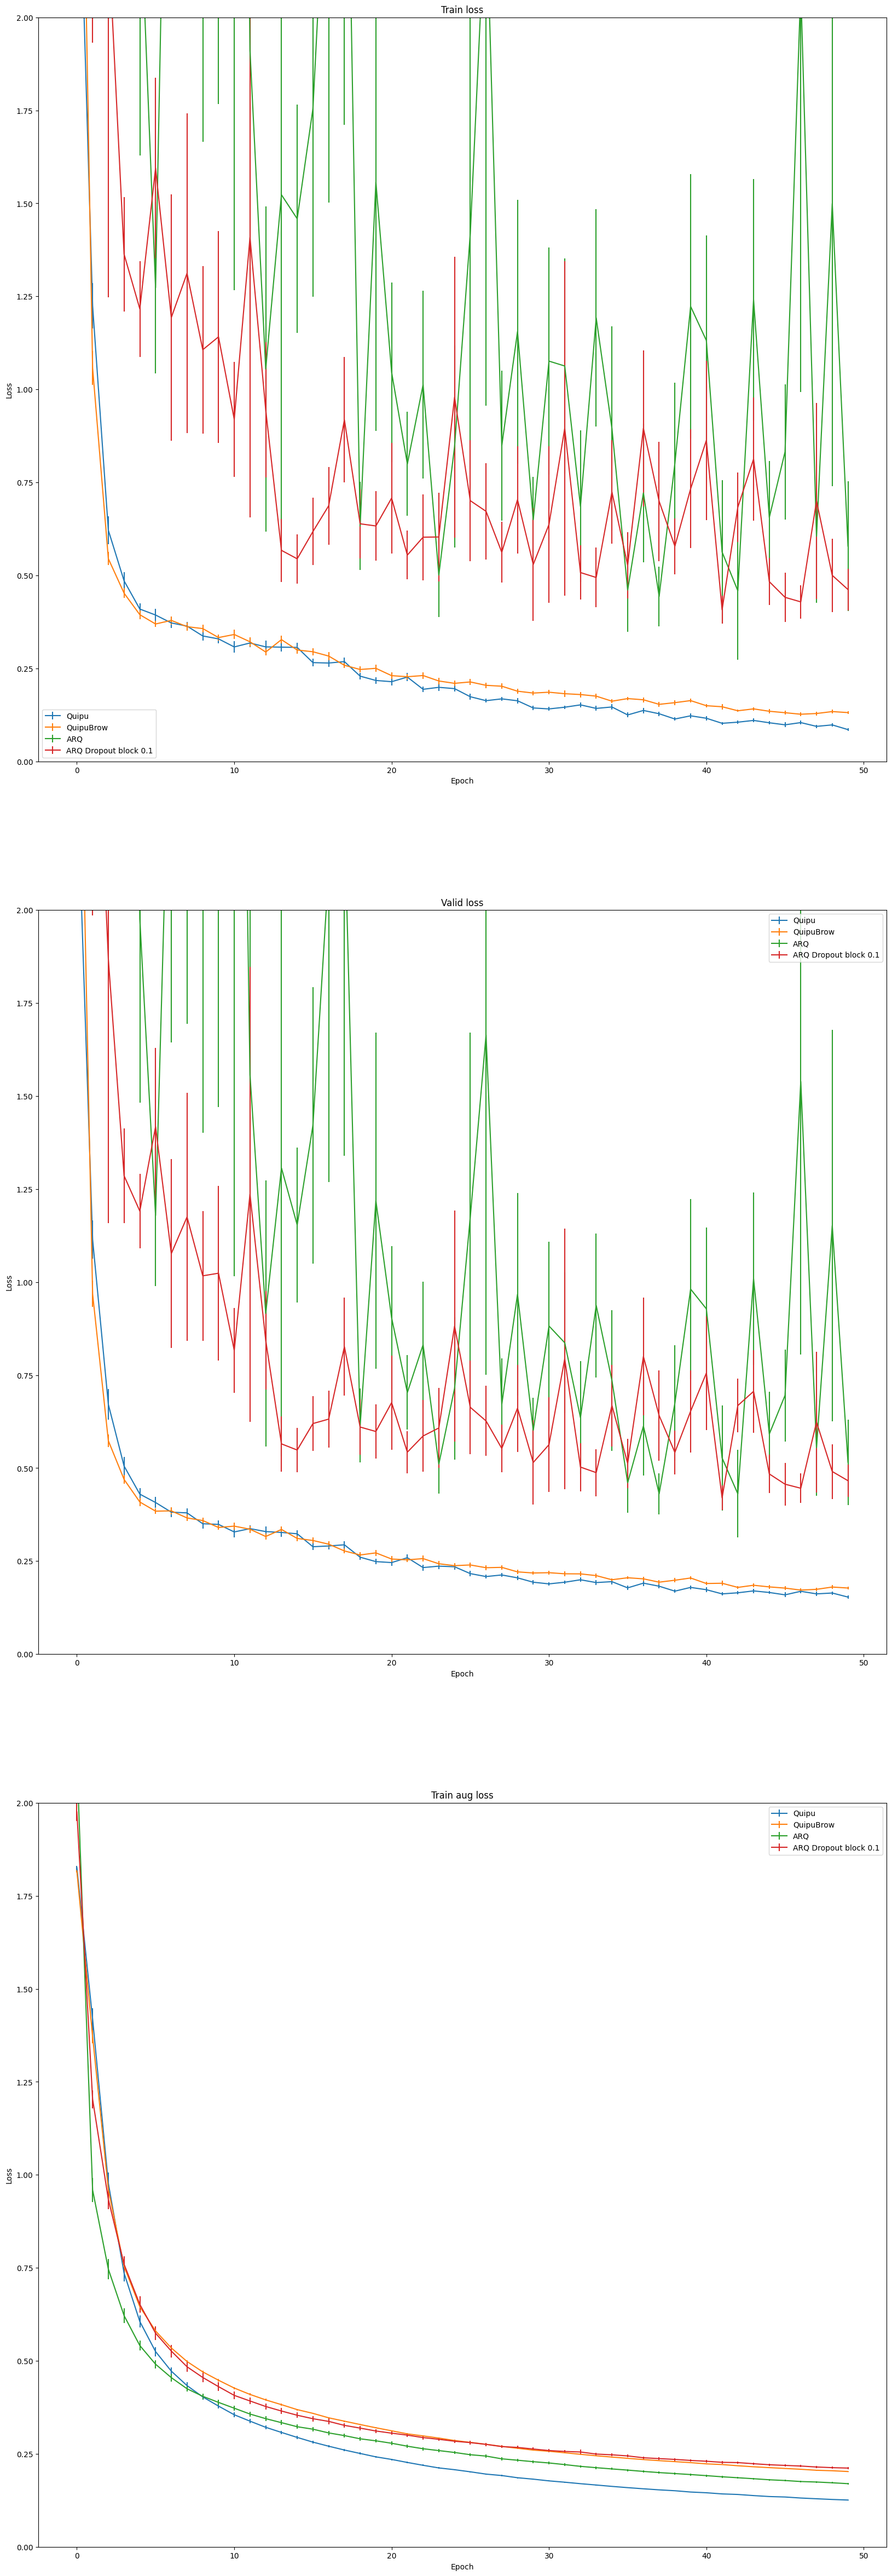

In [6]:

folder_tests,file_attresQuipuNoDropout=get_folder_and_filepath(results_newNN_folder,"Test","20240417_19-52-45_LR_log.txt")
df_AttResQuipu=get_runs_of_experiment(file_attresQuipuNoDropout,folder_tests)

folder_AttRes,file_attresQuipuDropout=get_folder_and_filepath(results_newNN_folder,"AttResQuipu","20240418_13-57-44_LR_log.txt")
df_AttResQuipuDropout=get_runs_of_experiment(file_attresQuipuDropout,folder_AttRes)

folder_Quipu,file_Quipu=get_folder_and_filepath(results_newNN_folder,"Quipu","20240419_12-10-05_QuipuNoBrow_log.txt")
df_Quipu=get_runs_of_experiment(file_Quipu,folder_Quipu)

folder_Quipu,file_QuipuBrow=get_folder_and_filepath(results_newNN_folder,"Quipu","20240419_10-59-10_LR_log.txt")
df_QuipuBrow=get_runs_of_experiment(file_QuipuBrow,folder_Quipu)

compare_dfs([df_Quipu,df_QuipuBrow,df_AttResQuipu,df_AttResQuipuDropout],["Quipu","QuipuBrow","ARQ","ARQ Dropout block 0.1"])

First: Quipu without brow has lower losses which makes sense, but in the test set we have shown before that after long training they kinda generalize similar (better with brow. So our baseline is the Quipu with brownian!  Anyways the structure proposed has very noisy train and valid losses, and higher than the quipu with brownian. So then we start searching other starting points to modify.

------------ Table comparison ----------------
                         Name      Train Accuracy      Valid Accuracy  \
0                   QuipuBrow  97.28+-0.38(97.97)  95.79+-0.36(96.45)   
1                QuipuResBrow  97.81+-0.21(98.20)  96.09+-0.30(96.75)   
2             QuipuAttResBrow  97.83+-0.27(98.17)  96.08+-0.31(96.55)   
3  QuipuAttResBrowMoreDropout  97.38+-0.33(97.93)  95.66+-0.36(96.88)   

        Test Accuracy  nRuns  
0  95.76+-0.35(96.42)     27  
1  96.04+-0.32(96.62)     42  
2  96.02+-0.36(96.71)     29  
3  95.68+-0.38(96.35)     28  
----------------------------------------------
------------ Plot comparison ----------------


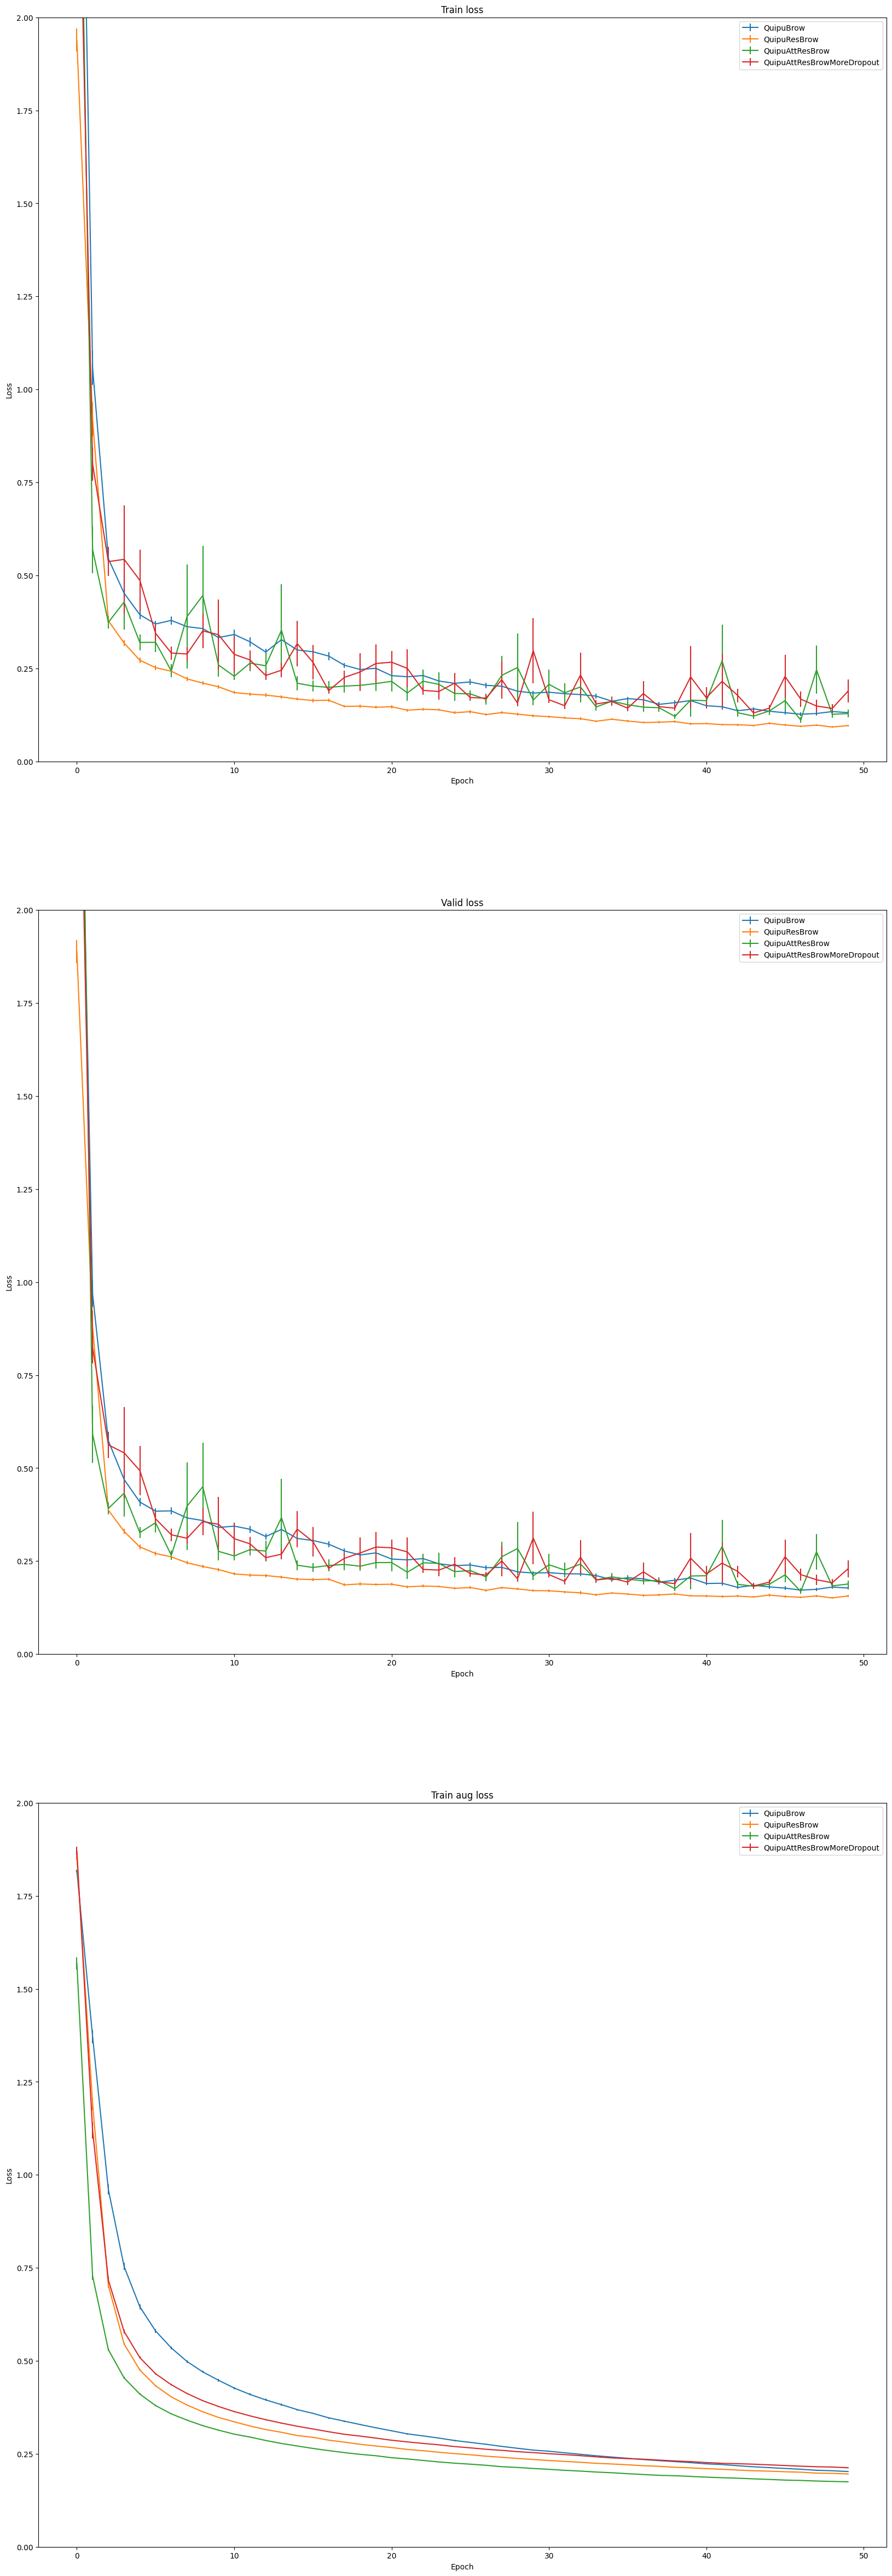

In [7]:
folder_quipumodif,file_QuipuRes=get_folder_and_filepath(results_newNN_folder,"QuipuModif","20240419_15-18-53_QuipuRes_log.txt")
df_QuipuRes=get_runs_of_experiment(file_QuipuRes,folder_quipumodif)

folder_quipumodif,file_QuipuAttRes=get_folder_and_filepath(results_newNN_folder,"QuipuModif","20240421_21-17-38_QuipuAttRes_log.txt")
df_QuipuAttRes=get_runs_of_experiment(file_QuipuAttRes,folder_quipumodif)

folder_quipumodif,file_QuipuAttResMoreDropout=get_folder_and_filepath(results_newNN_folder,"QuipuModif","20240422_10-47-52_QuipuAttResD_log.txt")
df_QuipuAttResMoreDropout=get_runs_of_experiment(file_QuipuAttResMoreDropout,folder_quipumodif)


compare_dfs([df_QuipuBrow,df_QuipuRes,df_QuipuAttRes,df_QuipuAttResMoreDropout],["QuipuBrow","QuipuResBrow","QuipuAttResBrow","QuipuAttResBrowMoreDropout"])

The residual looks with better results, and the skip connection had much more noisy curves. However this behaviour is suspected to be because of a bug given the axis of the batchnorm and multiply layers, so after 22/04/2024 18:00 this bugg is solved and ran again the same.

------------ Table comparison ----------------
              Name      Train Accuracy      Valid Accuracy  \
0        QuipuBrow  97.28+-0.38(97.97)  95.79+-0.36(96.45)   
1     QuipuResBrow  97.81+-0.21(98.20)  96.09+-0.30(96.75)   
2  QuipuAttResBrow  97.96+-0.25(98.36)  96.30+-0.26(96.73)   

        Test Accuracy  nRuns  
0  95.76+-0.35(96.42)     27  
1  96.04+-0.32(96.62)     42  
2  96.32+-0.30(96.84)     28  
----------------------------------------------
------------ Plot comparison ----------------


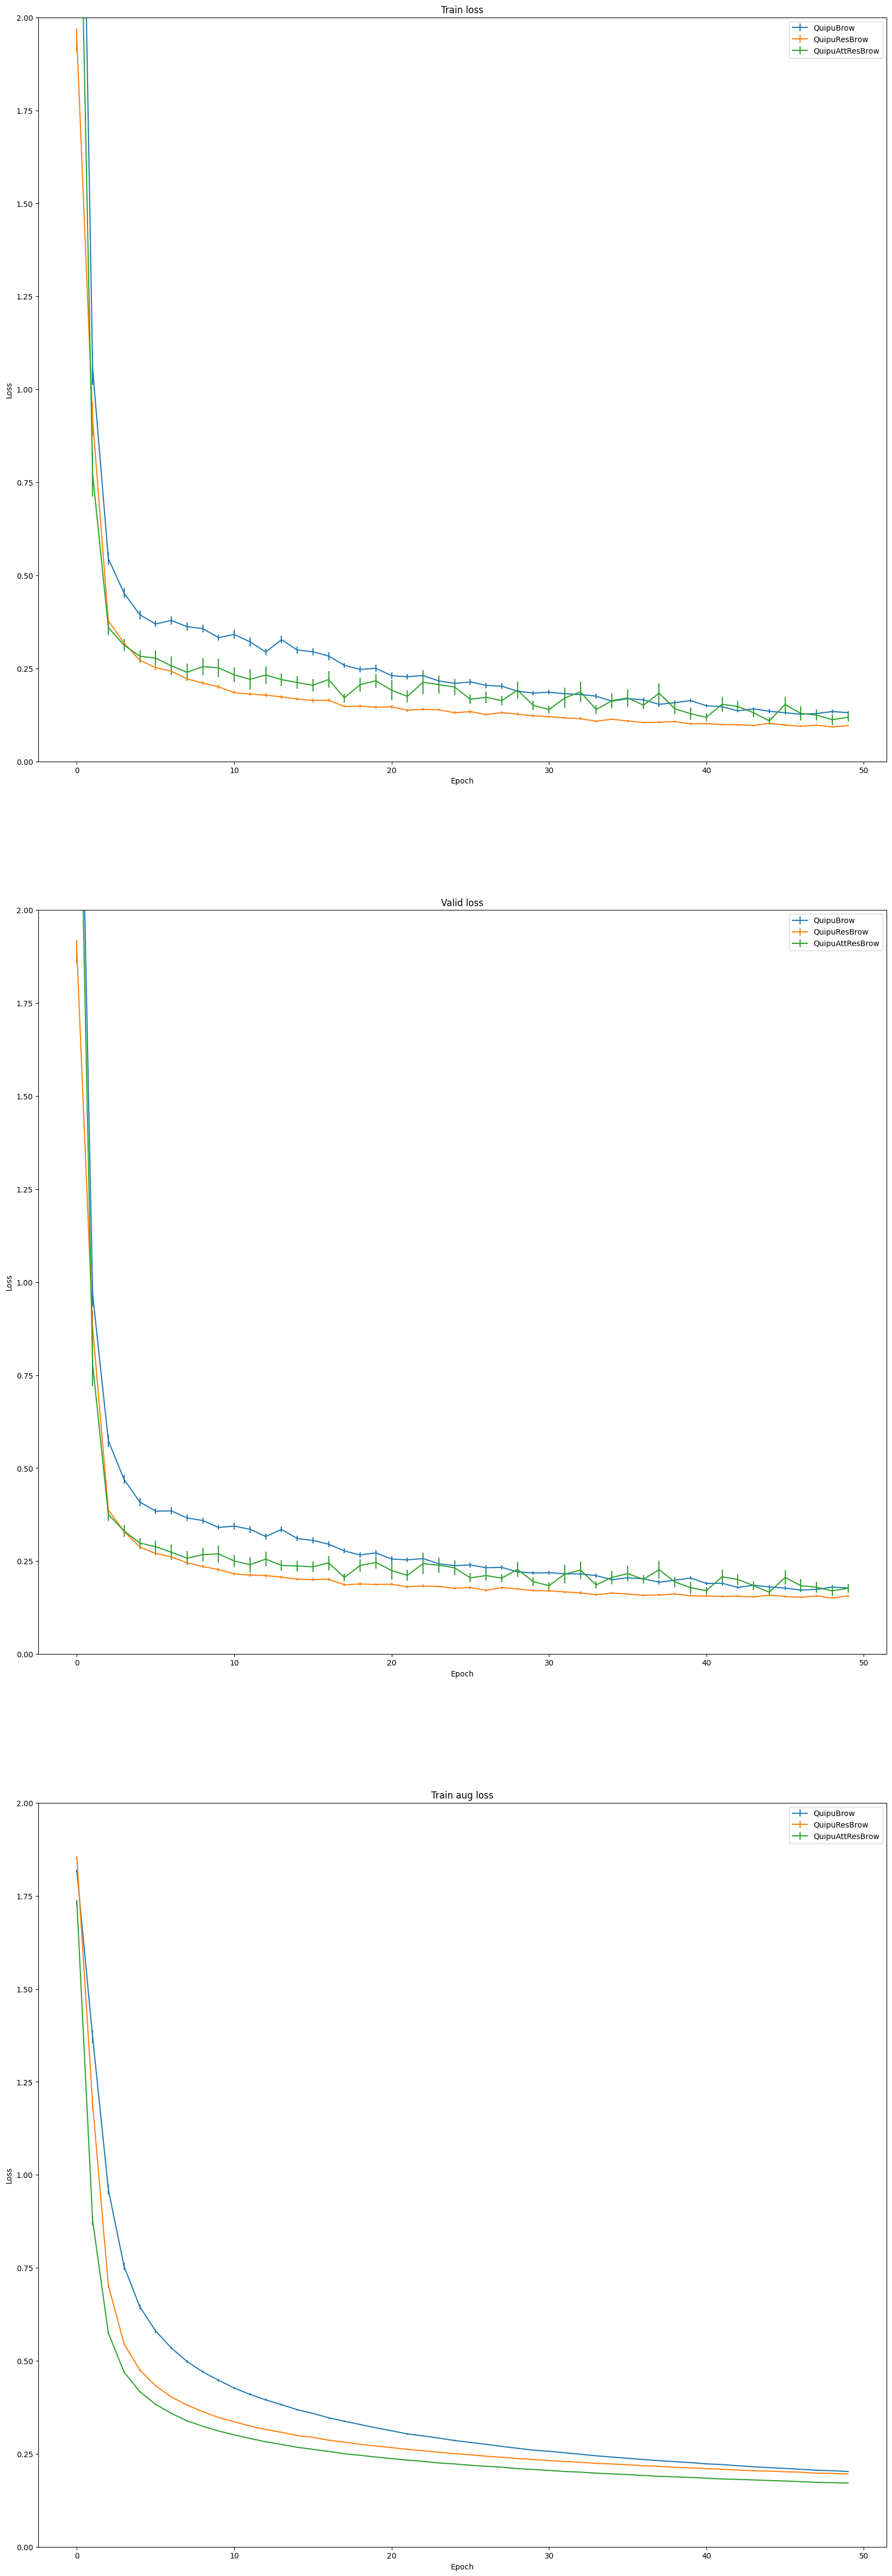

In [8]:
folder_quipumodif,file_QuipuAttRes=get_folder_and_filepath(results_newNN_folder,"QuipuModif","20240422_19-10-36_QuipuAttResD_log.txt")
df_QuipuAttRes=get_runs_of_experiment(file_QuipuAttRes,folder_quipumodif)

compare_dfs([df_QuipuBrow,df_QuipuRes,df_QuipuAttRes],["QuipuBrow","QuipuResBrow","QuipuAttResBrow"])

From this curves i interpret that the quipu with residual is always better in the curves, so definetely tuning it may lead to better results. With the attention block we can see that the training in the augmented dataset has a better loss curve, but on the real data we have much noisier performance. However on the statistics on the evaluating dataset we can see that it has good results the one with attention. My guess here is that we can tune the residual, which by having a more stable curve we can tune better, and then consider it with and without the attention module! Then we can evaluate.


## Tuning residual based on Quipu

Here we just use Quipu but we add residual connections to see if we spot a change

In [5]:
#Common results
df_Quipu=get_df(results_newNN_folder,"Quipu","20240419_10-59-10_LR_log.txt") #Quipu with brownian
df_QuipuRes=get_df(results_newNN_folder,"QuipuModif","20240419_15-18-53_QuipuRes_log.txt") #QuipuRes Same architecture and training as quipu

### Learning rate

------------ Table comparison ----------------
       Name      Train Accuracy      Valid Accuracy       Test Accuracy  nRuns
0  LR= 1e-3  97.81+-0.21(98.20)  96.09+-0.30(96.75)  96.04+-0.32(96.62)     42
1  LR= 2e-4  97.67+-0.35(98.24)  95.97+-0.44(96.65)  95.87+-0.37(96.82)     44
2  LR= 5e-4  98.02+-0.27(98.44)  96.21+-0.34(96.94)  96.12+-0.28(96.69)     39
----------------------------------------------
------------ Plot comparison ----------------


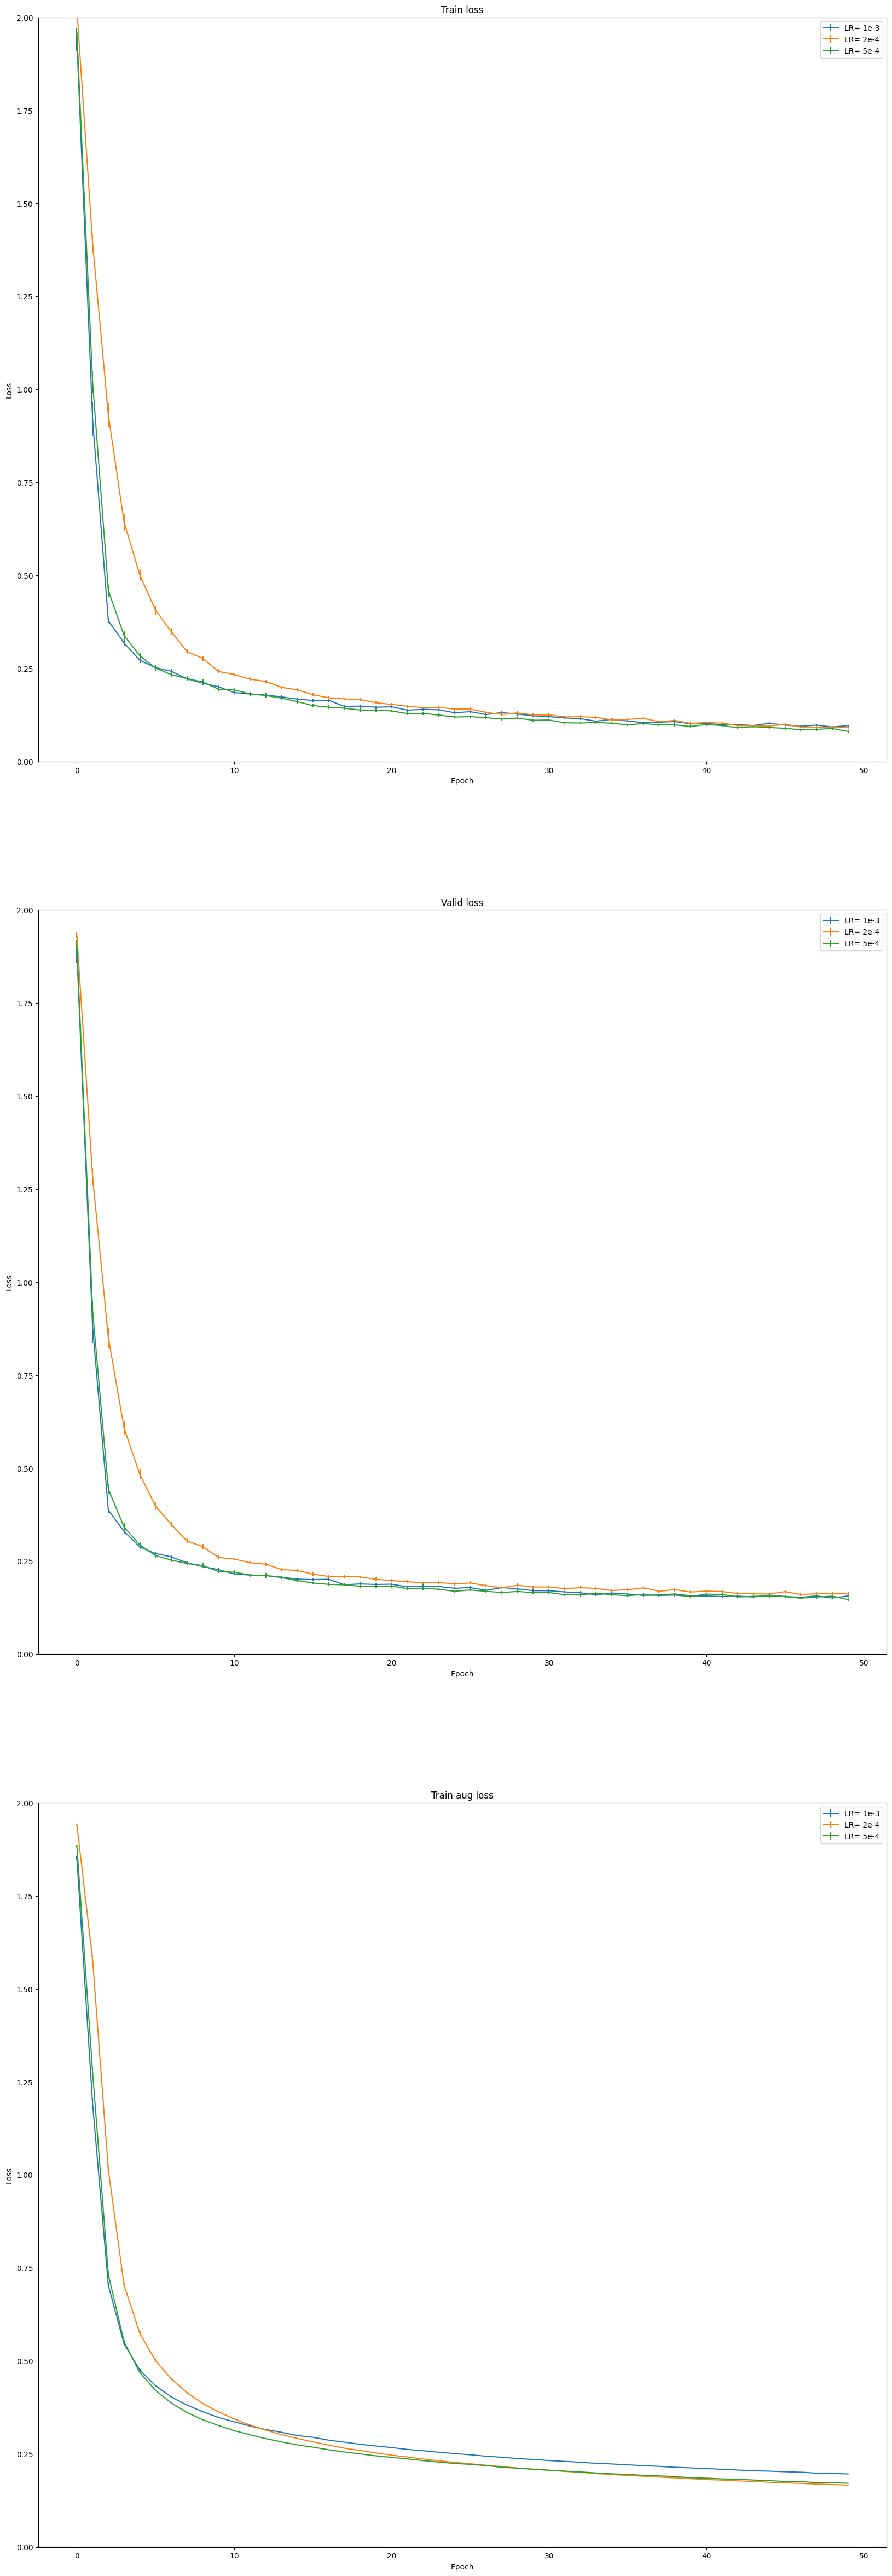

In [6]:
df_QR_LR_2em4=get_df(results_newNN_folder,"QuipuRes","20240423_13-53-28_QuipuResLR_log.txt") 
df_QR_LR_5em4=get_df(results_newNN_folder,"QuipuRes","20240423_13-54-14_QuipuResLR_log.txt") 

compare_dfs([df_QuipuRes,df_QR_LR_2em4,df_QR_LR_5em4],["LR= 1e-3","LR= 2e-4","LR= 5e-4"])

### Blocks

------------ Table comparison ----------------
                Name      Train Accuracy      Valid Accuracy  \
0       B= [7, 5, 3]  97.81+-0.21(98.20)  96.09+-0.30(96.75)   
1    B= [7, 5, 3, 3]  97.86+-0.24(98.32)  96.30+-0.29(96.88)   
2  B= [7,7, 5, 3, 3]  98.08+-0.27(98.44)  96.25+-0.32(96.88)   

        Test Accuracy  nRuns  
0  96.04+-0.32(96.62)     42  
1  96.25+-0.31(96.82)     37  
2  96.33+-0.29(96.79)     28  
----------------------------------------------
------------ Plot comparison ----------------


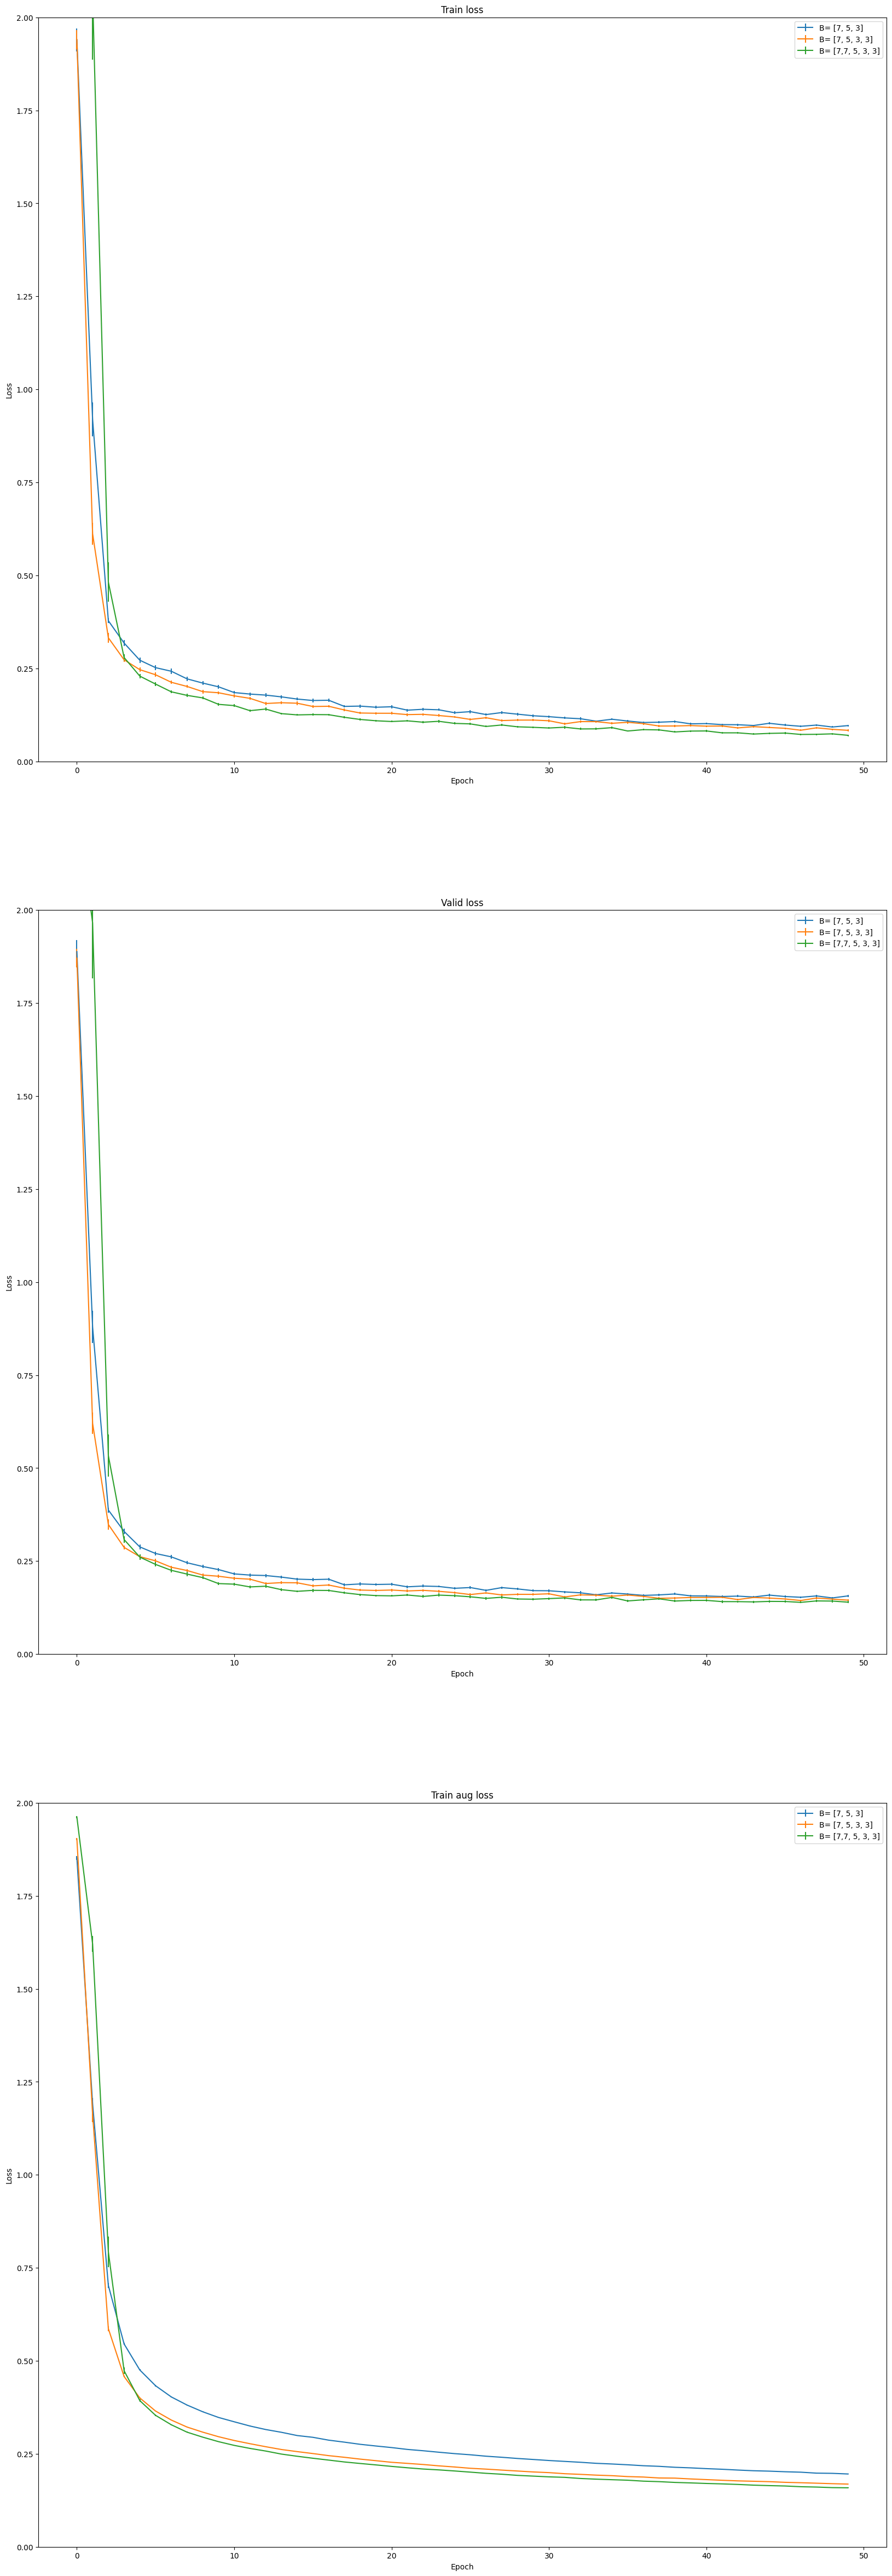

In [7]:
df_QR_Blocks_config1=get_df(results_newNN_folder,"QuipuRes","20240423_14-00-46_QuipuResBlock_log.txt") 
df_QR_Blocks_config2=get_df(results_newNN_folder,"QuipuRes","20240423_13-54-14_QuipuResBlock_log.txt") 

compare_dfs([df_QuipuRes,df_QR_Blocks_config1,df_QR_Blocks_config2],["B= [7, 5, 3]","B= [7, 5, 3, 3]","B= [7,7, 5, 3, 3]"])

### N dense 1


------------ Table comparison ----------------
        Name      Train Accuracy      Valid Accuracy       Test Accuracy  \
0   ND1= 512  97.81+-0.21(98.20)  96.09+-0.30(96.75)  96.04+-0.32(96.62)   
1  ND1= 1024  98.12+-0.19(98.48)  96.15+-0.27(96.77)  96.16+-0.31(96.88)   
2  ND1= 2048  98.32+-0.17(98.61)  96.29+-0.30(96.73)  96.27+-0.25(96.82)   

   nRuns  
0     42  
1     42  
2     31  
----------------------------------------------
------------ Plot comparison ----------------


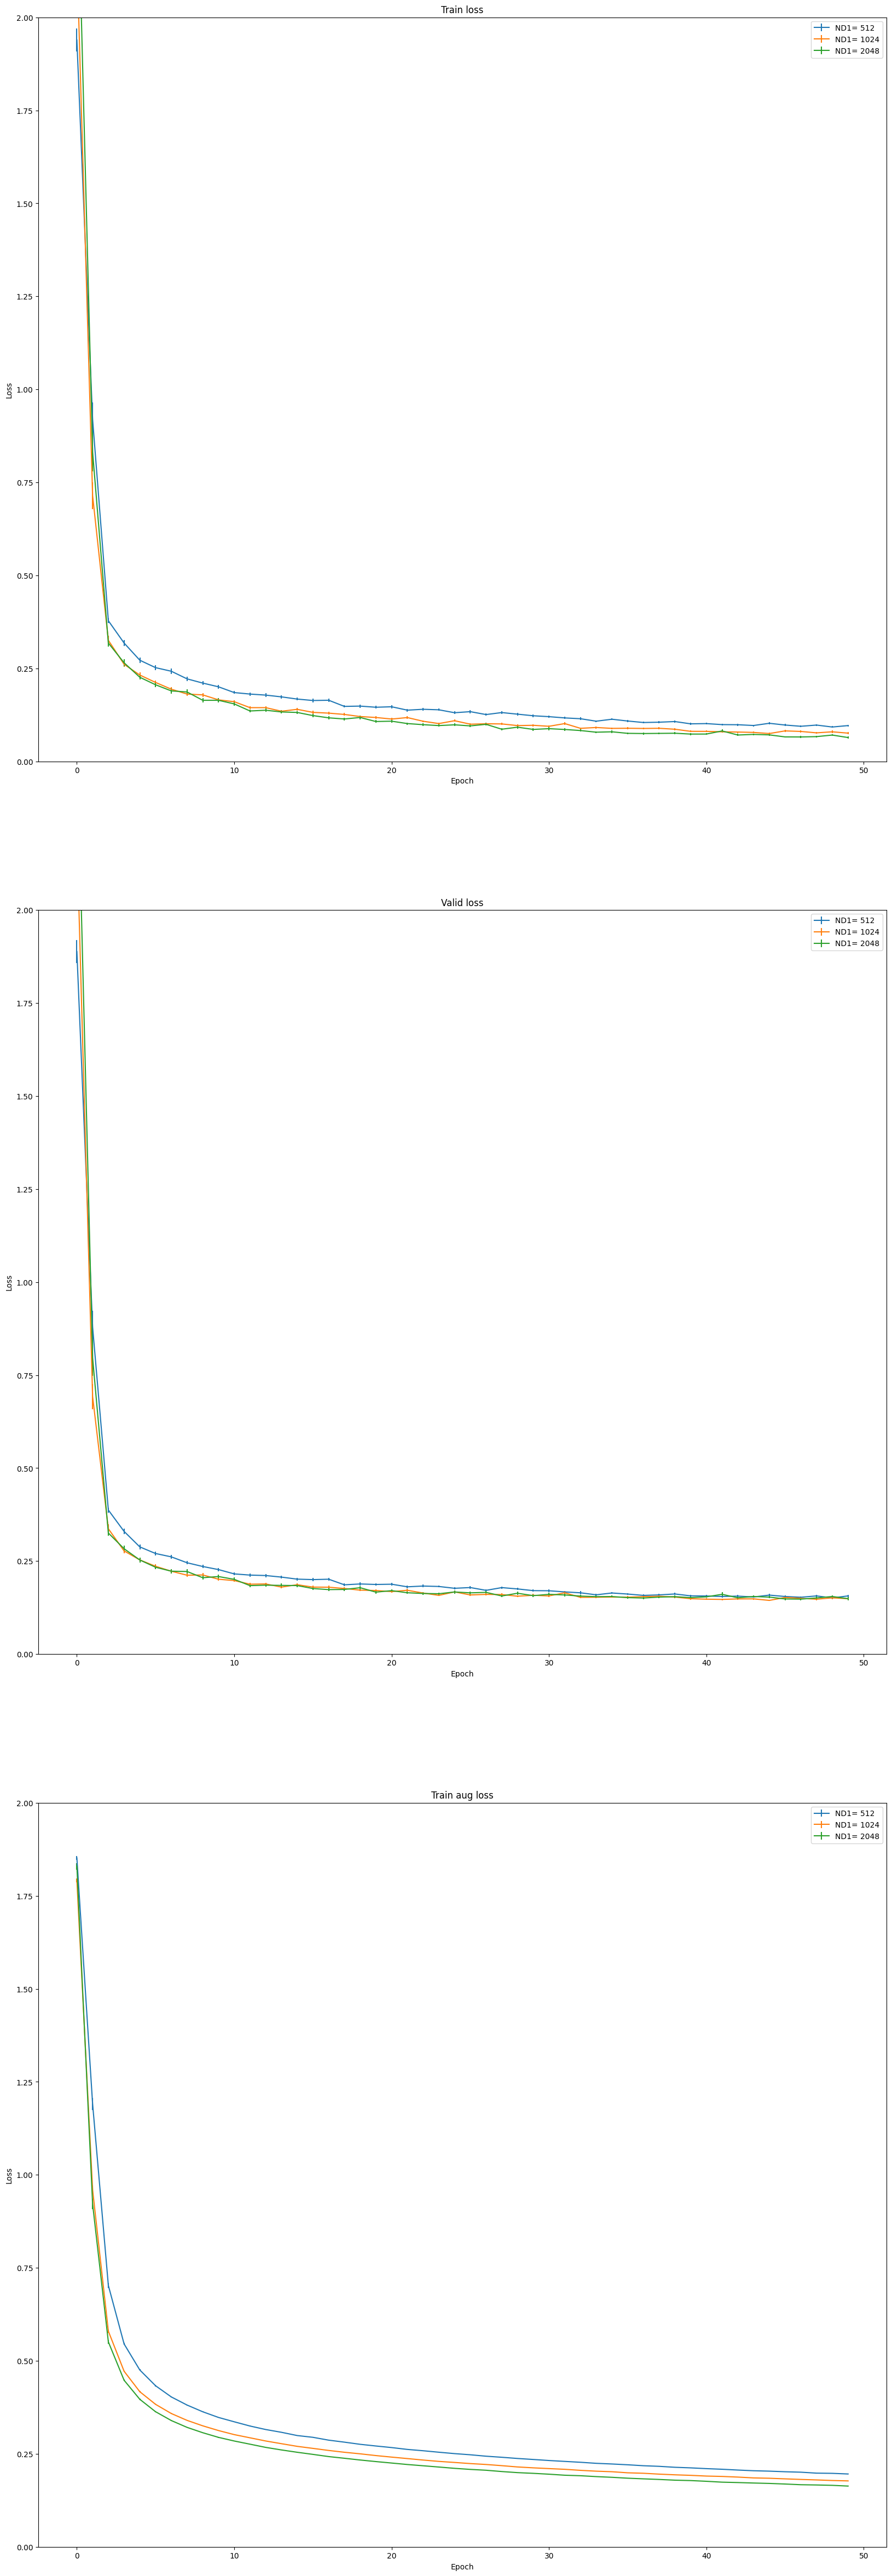

In [8]:
df_QR_Ndense1_1024=get_df(results_newNN_folder,"QuipuRes","20240423_13-52-10_QuipuResNdense1_log.txt") 
df_QR_Ndense1_2048=get_df(results_newNN_folder,"QuipuRes","20240423_13-52-25_QuipuResNdense1_log.txt") 

compare_dfs([df_QuipuRes,df_QR_Ndense1_1024,df_QR_Ndense1_2048],["ND1= 512","ND1= 1024","ND1= 2048"])

### Activation function
Here we replace relu with swish, which should be better for learning

------------ Table comparison ----------------
    Name      Train Accuracy      Valid Accuracy       Test Accuracy  nRuns
0   Relu  97.81+-0.21(98.20)  96.09+-0.30(96.75)  96.04+-0.32(96.62)     42
1  Swish  98.39+-0.24(98.67)  96.30+-0.28(97.04)  96.29+-0.27(96.66)     16
----------------------------------------------
------------ Plot comparison ----------------


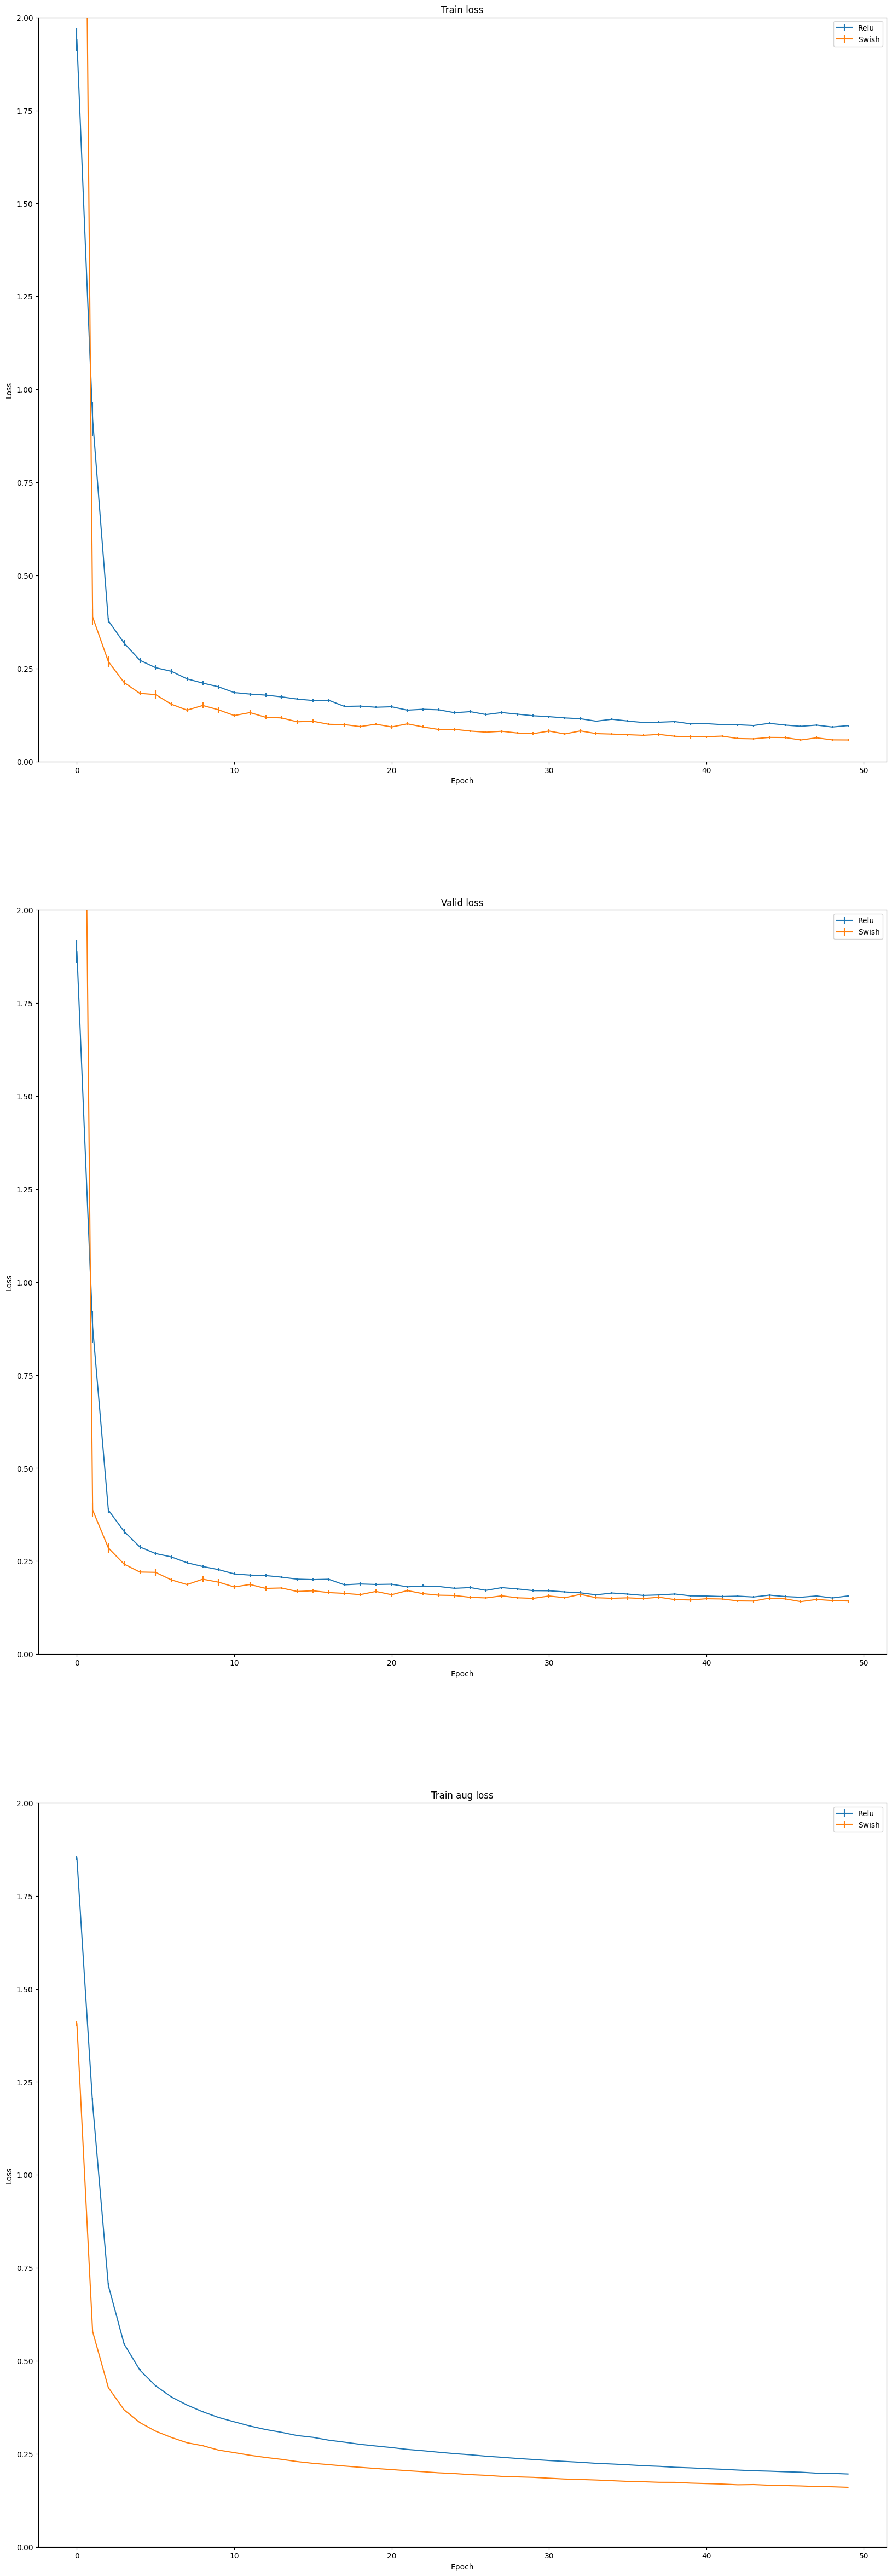

In [13]:
df_QR_swish=get_df(results_newNN_folder,"QuipuRes","20240424_11-07-41_QuipuResAct_log.txt") 

compare_dfs([df_QuipuRes,df_QR_swish],["Relu","Swish"]) 

## QuipuResV2
With this mini parameter search, we inculde the changes which we see as improving and compare to see improvements to the first suggestion:

------------ Table comparison ----------------
              Name      Train Accuracy      Valid Accuracy  \
0      Quipu(Brow)  97.28+-0.38(97.97)  95.79+-0.36(96.45)   
1         QuipuRes  97.81+-0.21(98.20)  96.09+-0.30(96.75)   
2       QuipuResv2  98.39+-0.24(98.67)  96.30+-0.28(97.04)   
3  QuipuResv2Swish  98.57+-0.23(98.90)  96.59+-0.26(97.10)   

        Test Accuracy  nRuns  
0  95.76+-0.35(96.42)     27  
1  96.04+-0.32(96.62)     42  
2  96.29+-0.27(96.66)     16  
3  96.46+-0.28(96.97)     12  
----------------------------------------------
------------ Plot comparison ----------------


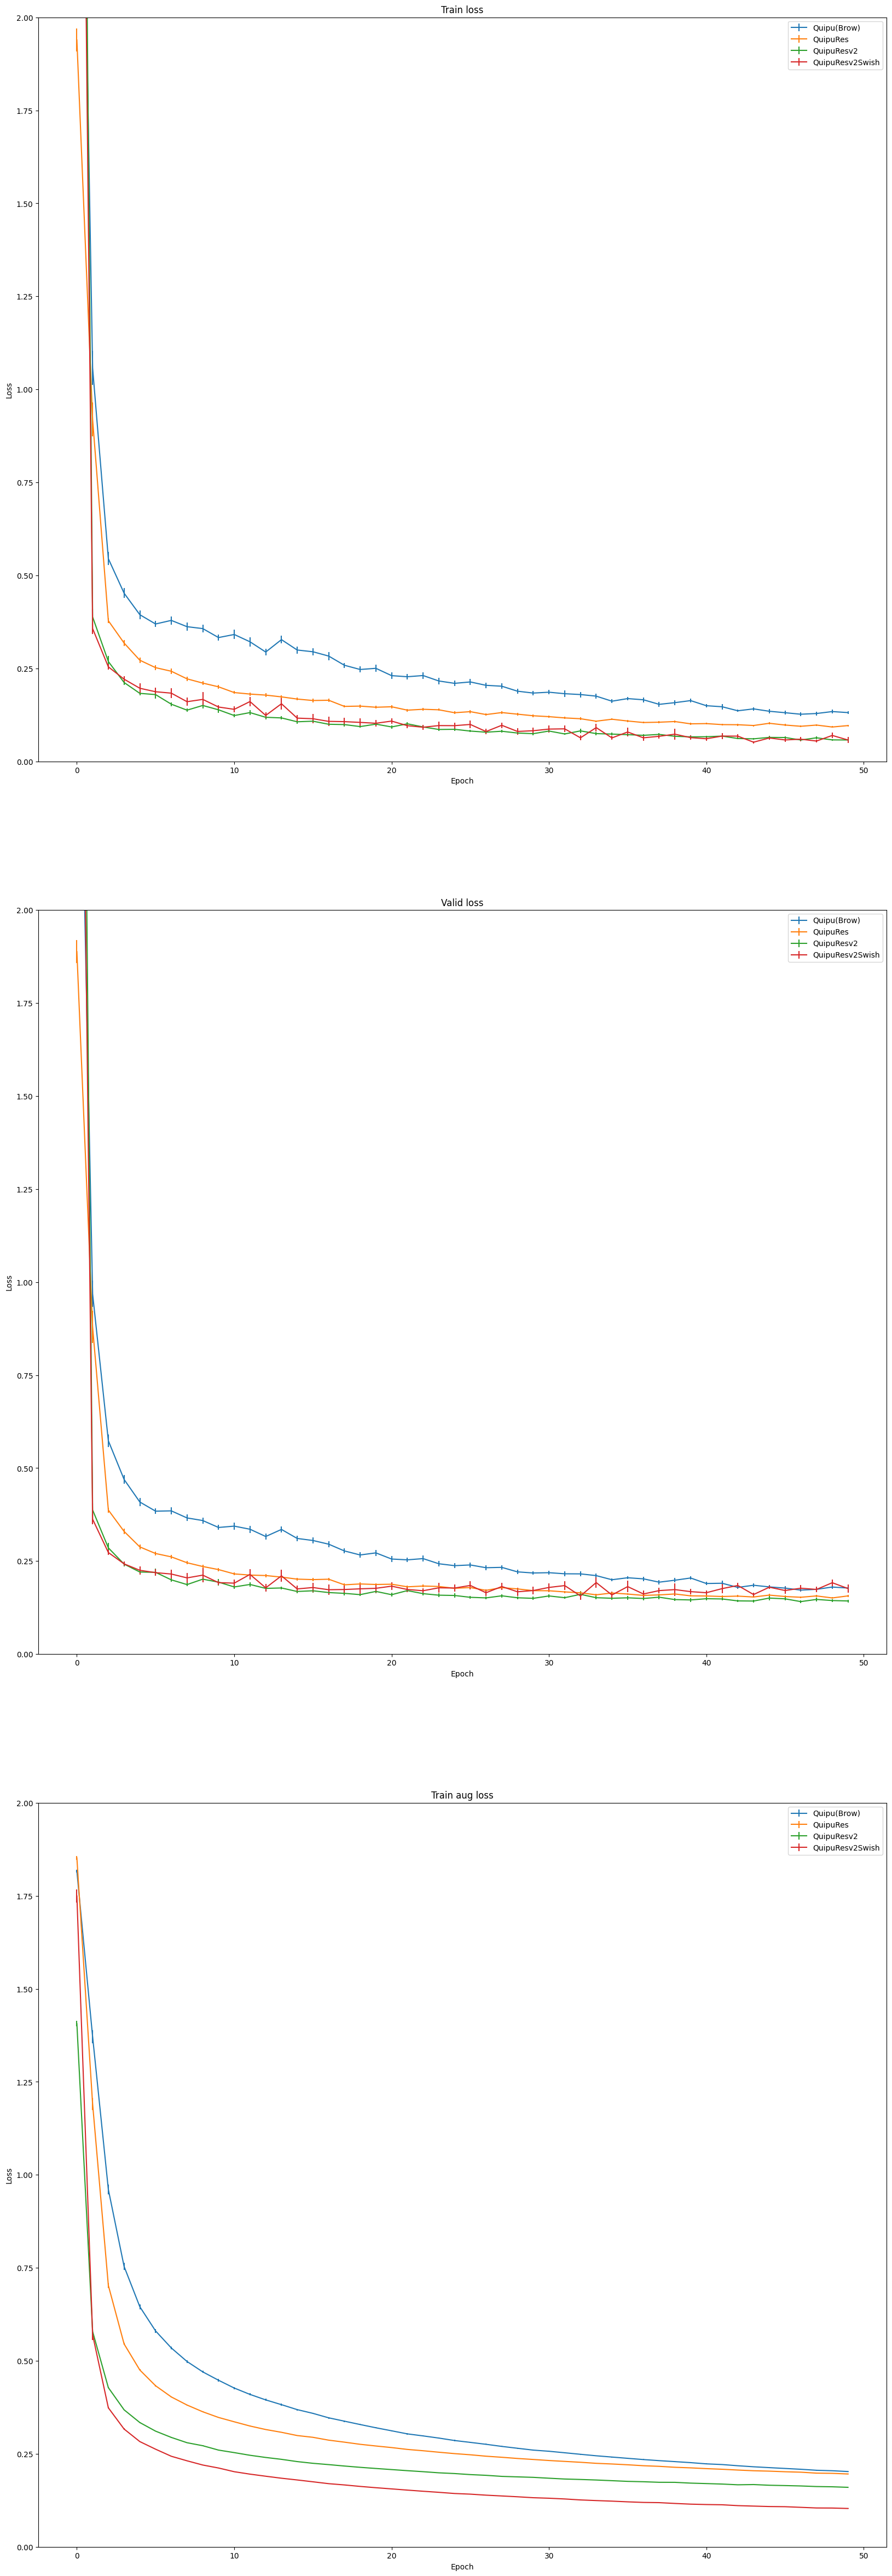

In [21]:
df_QRv2=get_df(results_newNN_folder,"QuipuRes","20240424_11-16-16_QuipuResV2_log.txt") 
df_QRv2S=get_df(results_newNN_folder,"QuipuRes","20240424_13-55-12_QuipuResV2S_log.txt") 

compare_dfs([df_QuipuBrow,df_QuipuRes,df_QR_swish,df_QRv2S],["Quipu(Brow)","QuipuRes","QuipuResv2","QuipuResv2Swish"])

## Running again tuning with 100 epochs
Since the final results we get them with 100 epochs, we also noticed in test dataset that quipu continues to decrease while the resnet doesnt. So now we will try to tune and optimize the models for 100 epochs. First we run with different Learning rates and checking which previous structure works well

### Common

In [5]:
df100_Quipu=get_df(results_newNN_folder,"QuipuRes","20240424_16-19-19_Quipu_log.txt") #Quipu with brow on 100 epochs

### Tuning of LR and model parameters

------------ Table comparison ----------------
                Name      Train Accuracy      Valid Accuracy  \
0        Quipu(Brow)  98.51+-0.11(98.73)  96.52+-0.30(97.02)   
1  QuipuResS LR=1E-4  98.82+-0.23(99.14)  95.90+-0.45(96.31)   
2  QuipuResS LR=2E-4  98.71+-0.35(99.36)  96.31+-0.23(96.57)   

        Test Accuracy  nRuns  
0  96.38+-0.23(96.71)     15  
1  96.00+-0.23(96.38)      5  
2  96.40+-0.24(96.75)      9  
----------------------------------------------
------------ Plot comparison ----------------


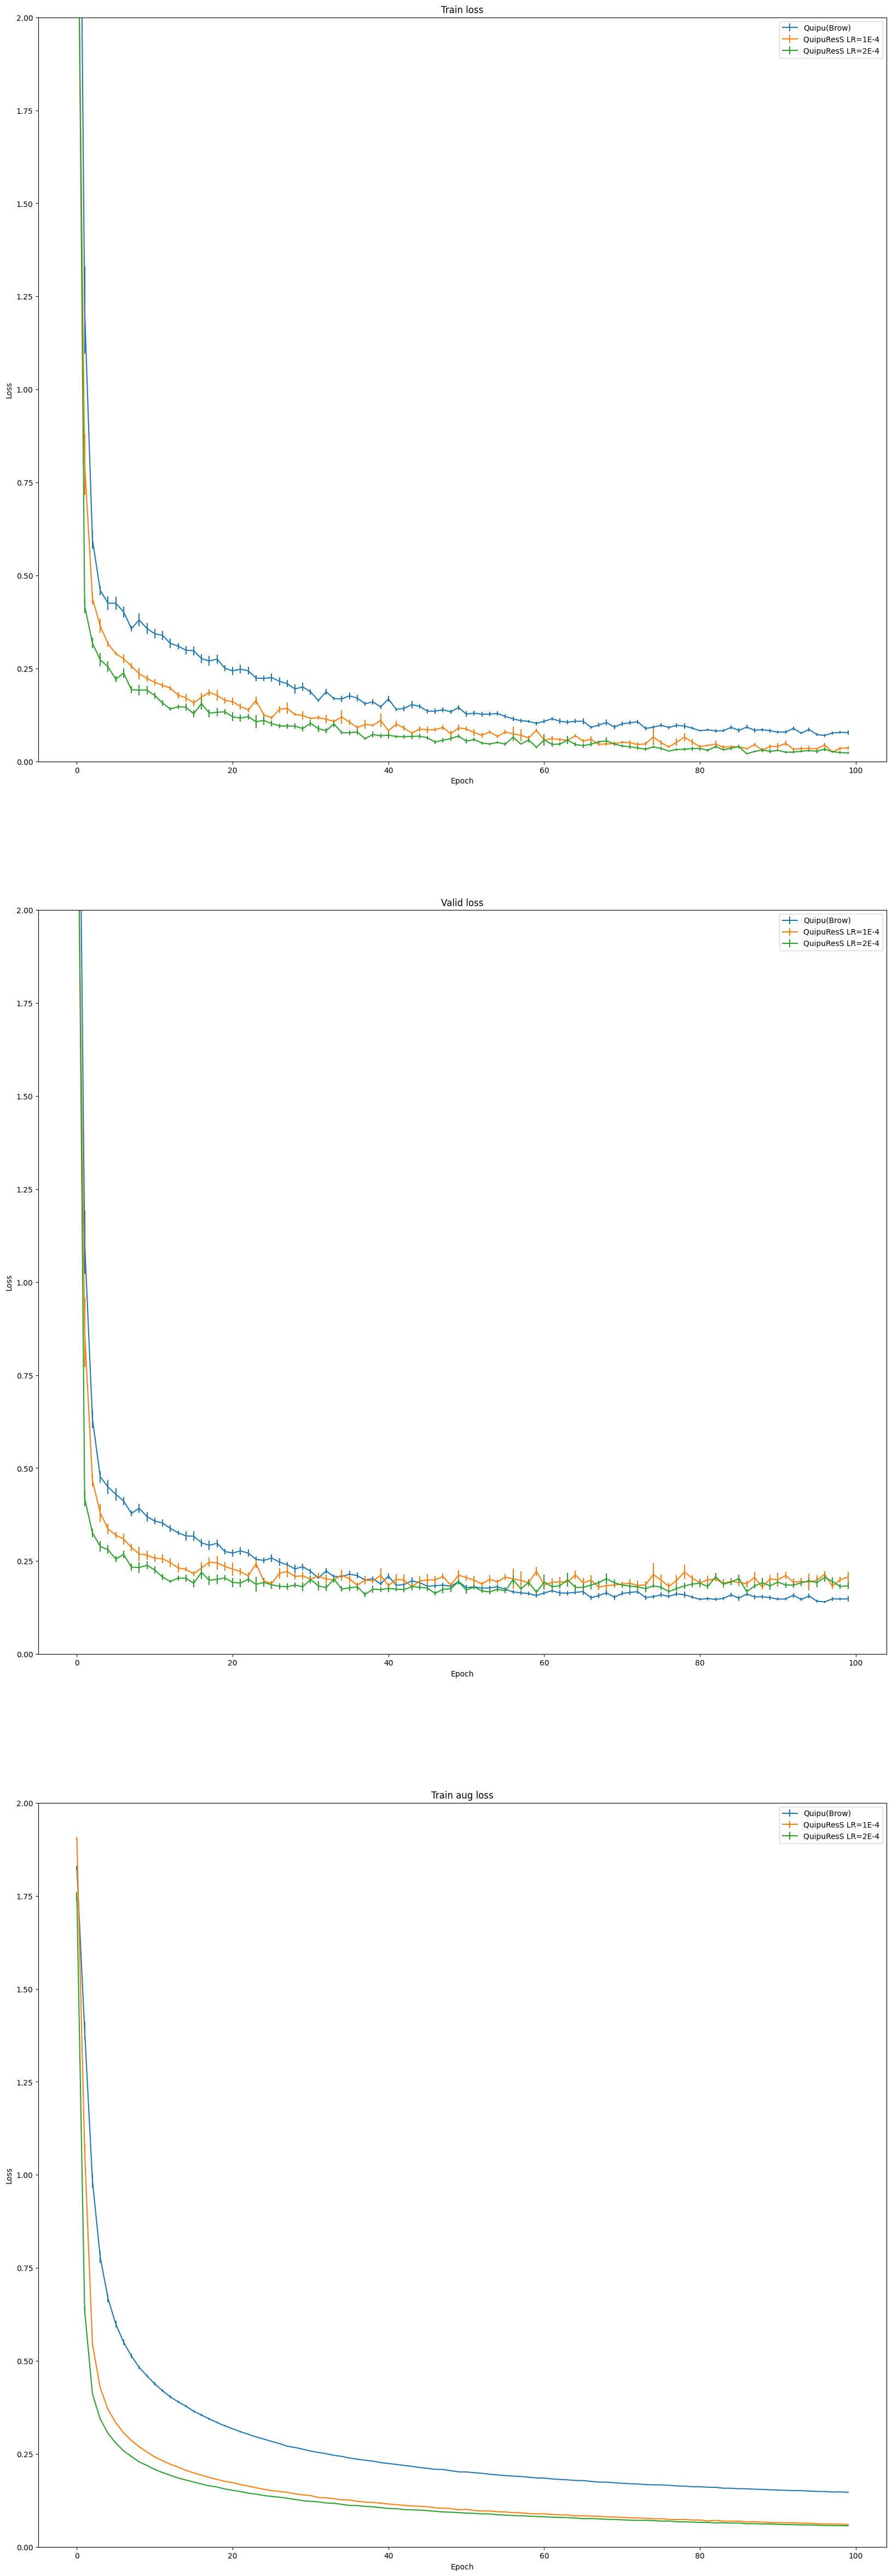

In [7]:
df100_QRS_LR1E4=get_df(results_newNN_folder,"QuipuRes","20240424_16-08-56_QuipuRS_LR_log.txt") 
df100_QRS_LR2E4=get_df(results_newNN_folder,"QuipuRes","20240424_16-12-24_QuipuRS_LR_log.txt") 



compare_dfs([df100_Quipu,df100_QRS_LR1E4,df100_QRS_LR2E4],["Quipu(Brow)","QuipuResS LR=1E-4","QuipuResS LR=2E-4"])

------------ Table comparison ----------------
                    Name      Train Accuracy      Valid Accuracy  \
0            Quipu(Brow)  98.51+-0.11(98.73)  96.52+-0.30(97.02)   
1       QuipuRes LR=2E-4  98.44+-0.52(99.24)  96.60+-0.13(96.81)   
2  QuipuRes Dont overfit  97.88+-0.24(98.14)  95.59+-0.25(96.08)   

        Test Accuracy  nRuns  
0  96.38+-0.23(96.71)     15  
1  96.45+-0.22(96.79)     10  
2  95.87+-0.23(96.31)      5  
----------------------------------------------
------------ Plot comparison ----------------


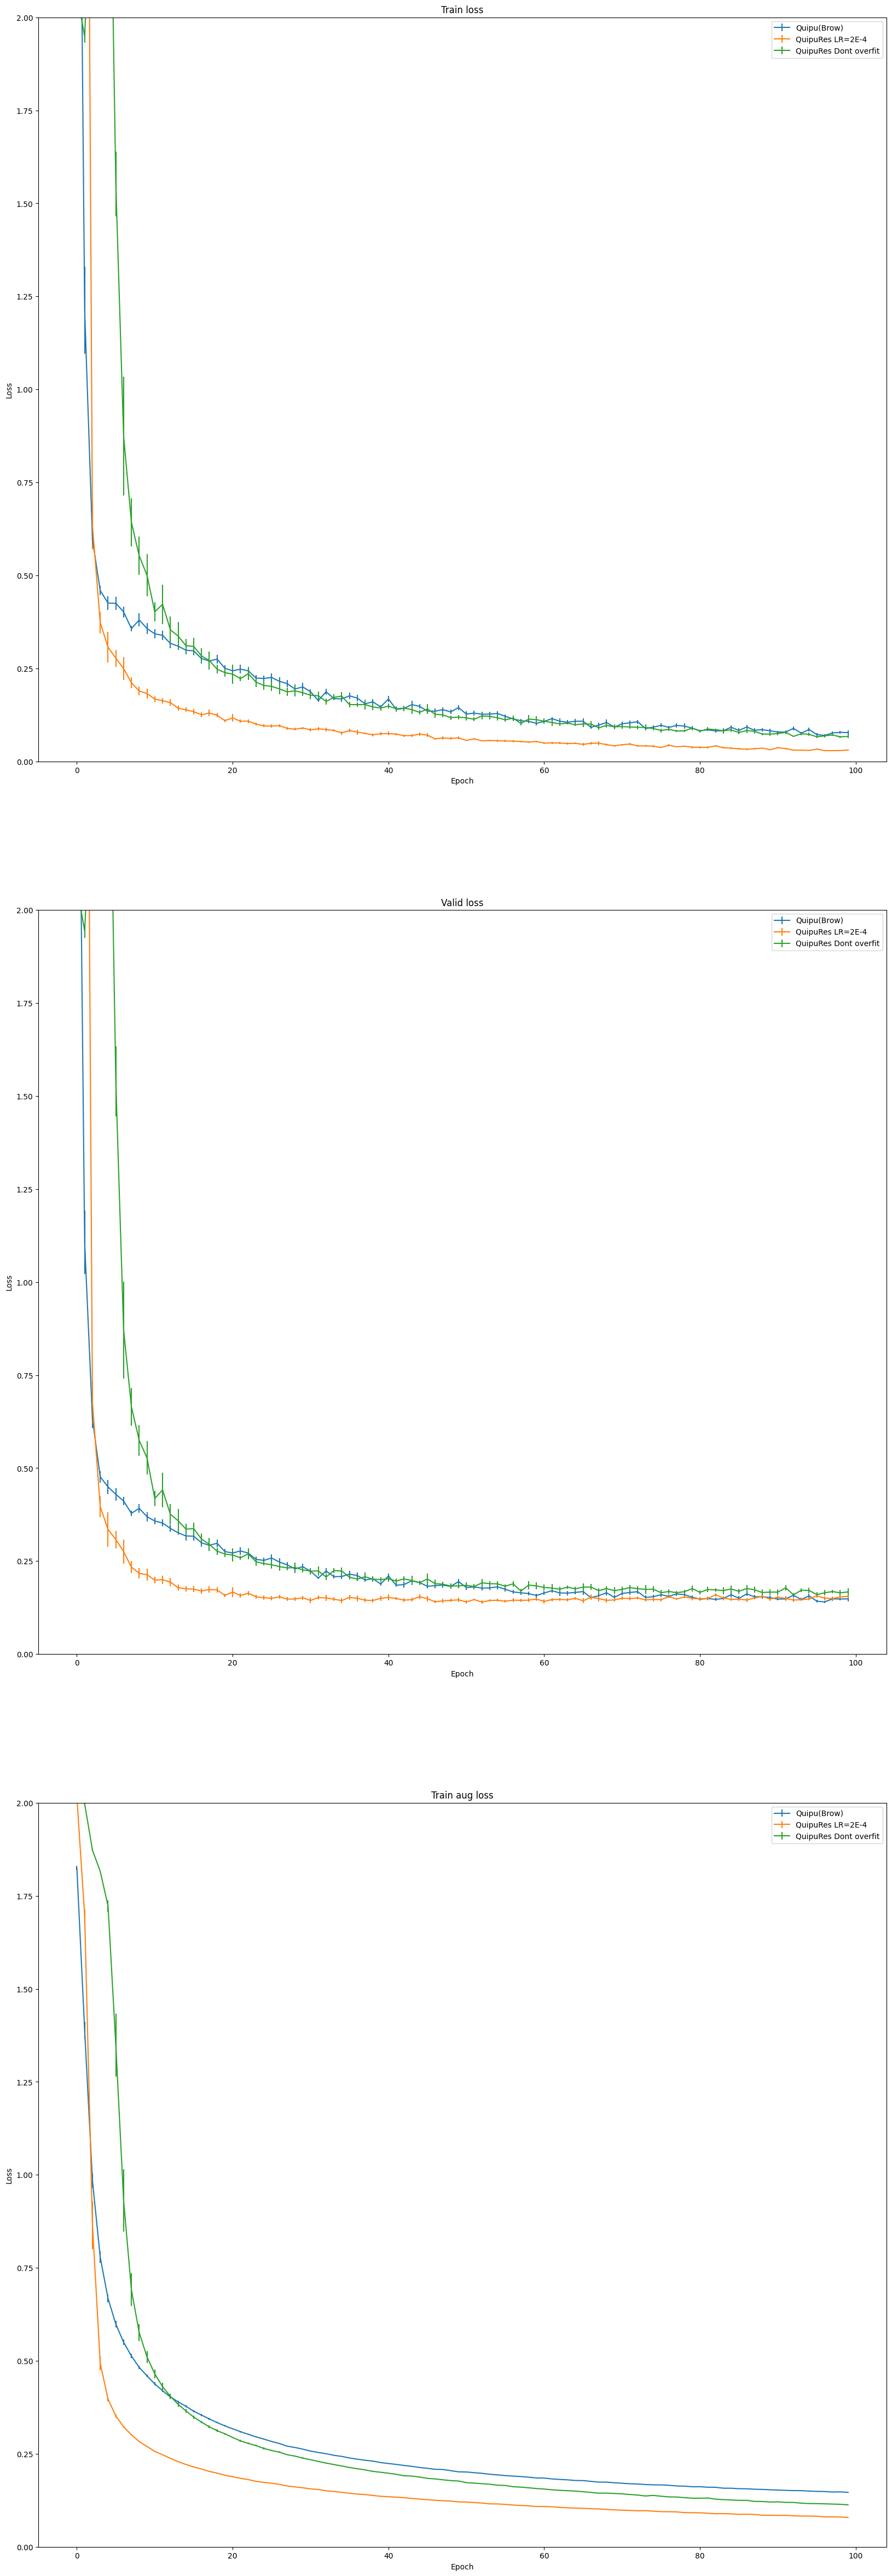

In [8]:
df100_QR_LR2E4=get_df(results_newNN_folder,"QuipuRes","20240424_16-34-48_Quipu_log.txt")  #Residual without swish act!
df100_QR_DO=get_df(results_newNN_folder,"QuipuRes","20240424_17-15-06_QuipuResDontOverfit_log.txt")  #Residual without swish act, but should generalize better (lr=1e-5, dropout final 0.5)

compare_dfs([df100_Quipu,df100_QR_LR2E4,df100_QR_DO],["Quipu(Brow)","QuipuRes LR=2E-4","QuipuRes Dont overfit"])

### Tuning of data augmentation parameters

#### BrownianAug

------------ Table comparison ----------------
               Name      Train Accuracy      Valid Accuracy  \
0  QuipuRes Brow 08  98.57+-0.44(99.13)  96.26+-0.19(96.55)   
1  QuipuRes Brow 09  98.31+-0.53(99.20)  96.23+-0.21(96.61)   
2   QuipuRes Brow 1  98.19+-0.39(98.78)  95.87+-0.31(96.23)   

        Test Accuracy  nRuns  
0  96.24+-0.31(96.90)     15  
1  96.21+-0.31(96.90)     14  
2  96.01+-0.33(96.49)     15  
----------------------------------------------
------------ Plot comparison ----------------


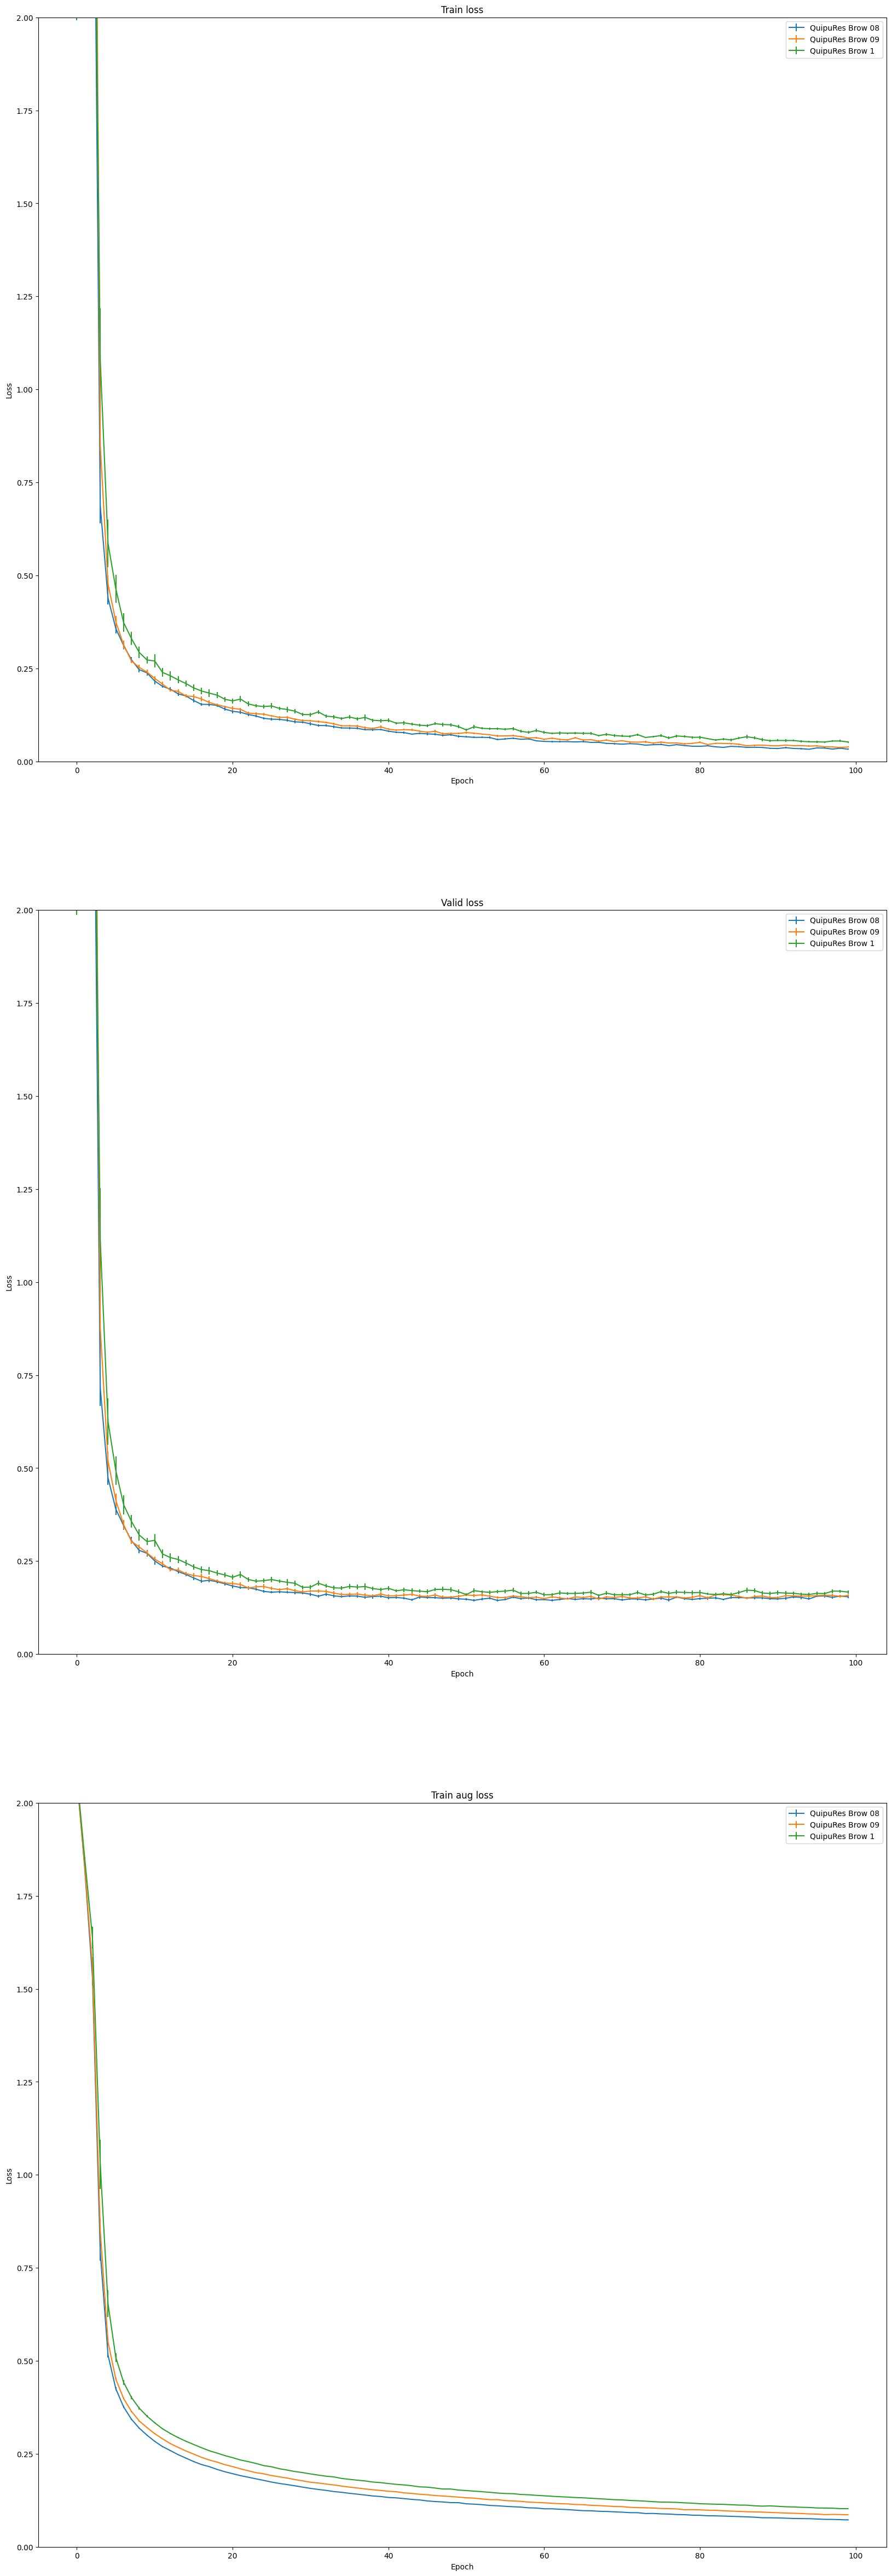

In [6]:

df100_QuipuBrow08=get_df(results_newNN_folder,"QuipuRes","20240425_09-58-18_QuipuResAug_log.txt") 
df100_QuipuBrow1=get_df(results_newNN_folder,"QuipuRes","20240425_09-59-15_QuipuResAug_log.txt") 
df100_QuipuBrow09=get_df(results_newNN_folder,"QuipuRes","20240425_10-03-51_QuipuResAug_log.txt") 

df100_QuipuResBase=df100_QuipuBrow09

compare_dfs([df100_QuipuBrow08,df100_QuipuBrow09,df100_QuipuBrow1],["QuipuRes Brow 08","QuipuRes Brow 09","QuipuRes Brow 1"])

------------ Table comparison ----------------
              Name      Train Accuracy      Valid Accuracy  \
0  QuipuRes Mag 05  98.31+-0.53(99.20)  96.23+-0.21(96.61)   
1  QuipuRes Mag 08  98.58+-0.44(99.02)  96.28+-0.31(96.79)   

        Test Accuracy  nRuns  
0  96.21+-0.31(96.90)     14  
1  96.28+-0.35(96.79)     15  
----------------------------------------------
------------ Plot comparison ----------------


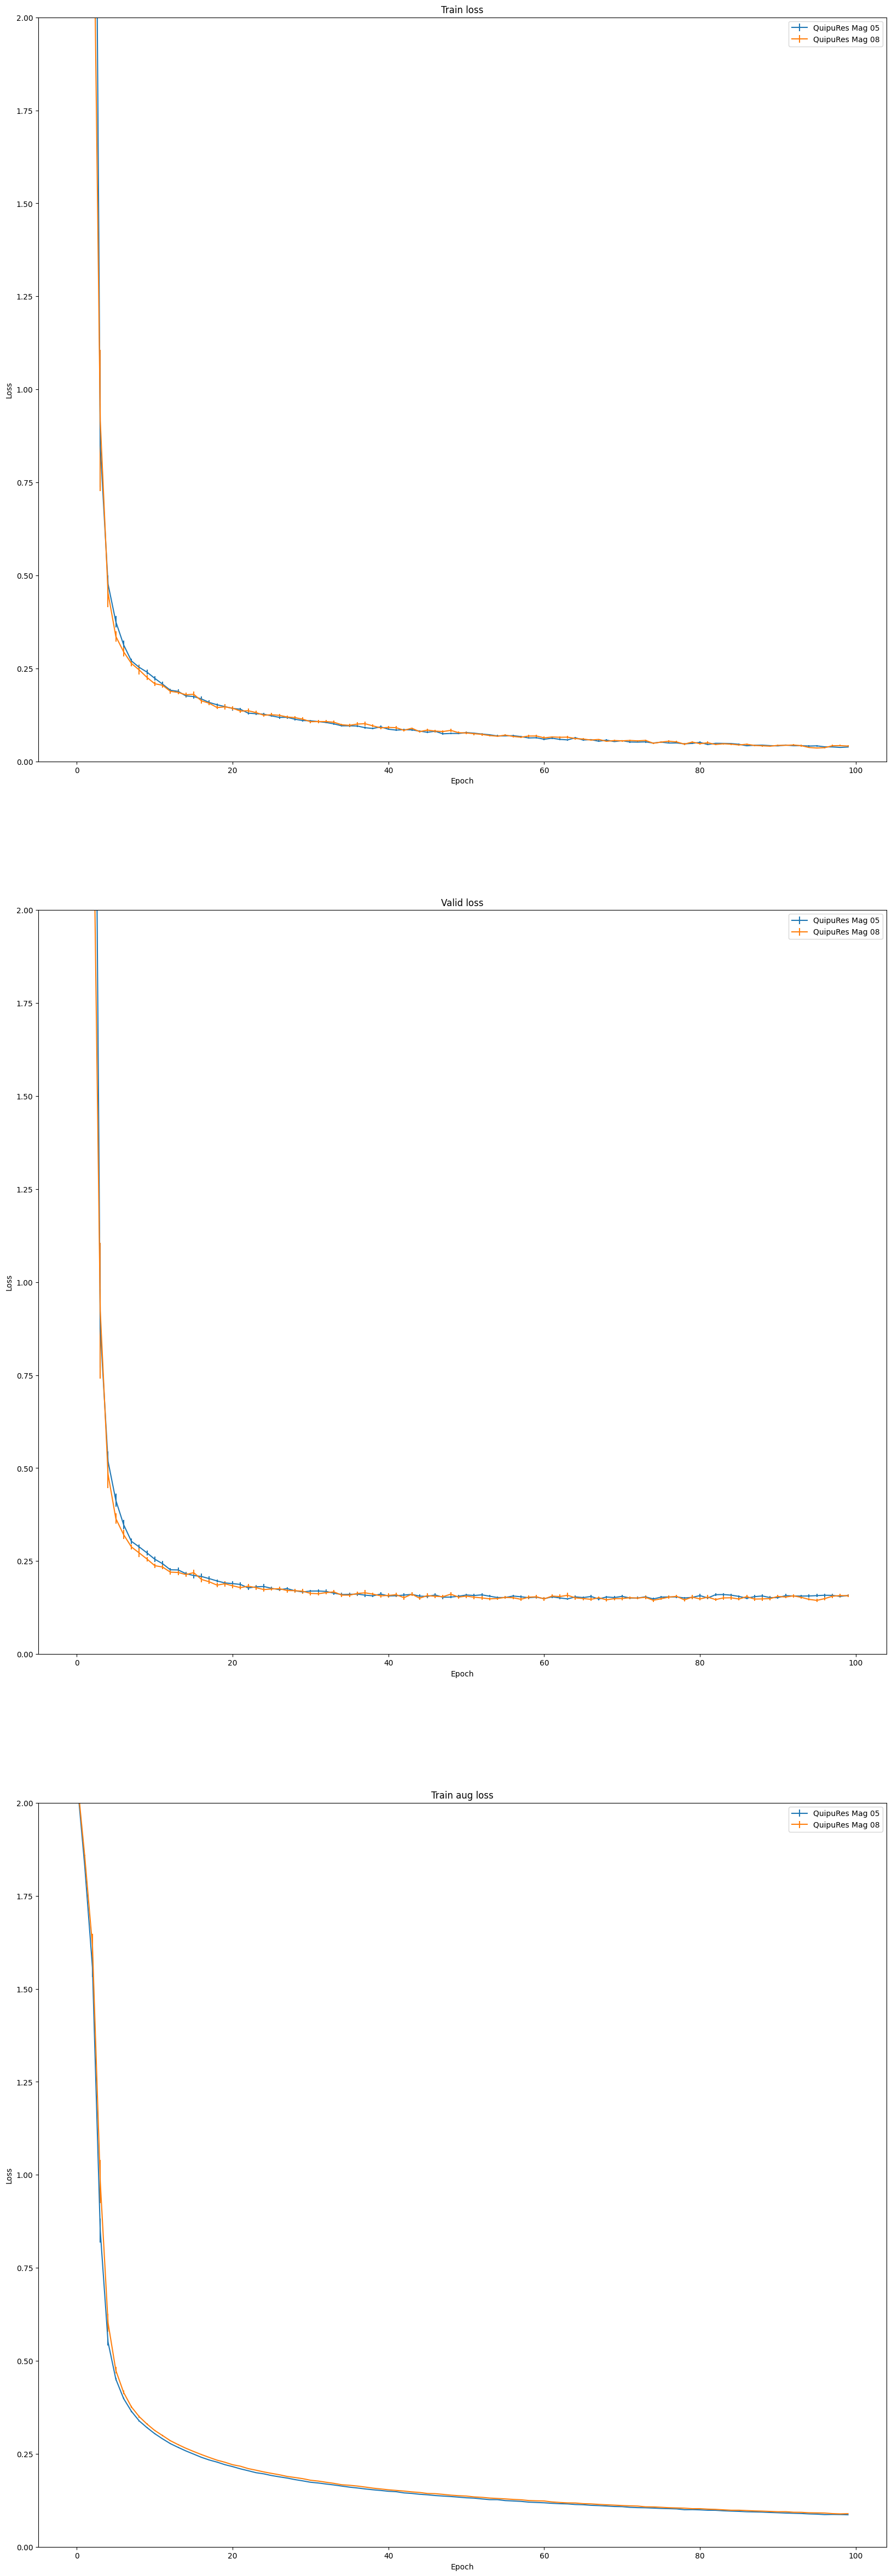

In [8]:
#Magnitude
df100_QuipuMag08=get_df(results_newNN_folder,"QuipuRes","20240425_10-09-29_QuipuResAug_log.txt") 

df100_QuipuMag05=df100_QuipuResBase;

compare_dfs([df100_QuipuMag05,df100_QuipuMag08],["QuipuRes Mag 05","QuipuRes Mag 08"])

------------ Table comparison ----------------
                Name      Train Accuracy      Valid Accuracy  \
0  QuipuRes Noise 04  98.31+-0.53(99.20)  96.23+-0.21(96.61)   
1  QuipuRes Noise 02  98.96+-0.35(99.49)  96.97+-0.33(97.52)   
2  QuipuRes Noise 08  98.66+-0.26(99.00)  96.45+-0.27(96.92)   

        Test Accuracy  nRuns  
0  96.21+-0.31(96.90)     14  
1  96.69+-0.26(97.13)     16  
2  96.27+-0.28(96.95)     15  
----------------------------------------------
------------ Plot comparison ----------------


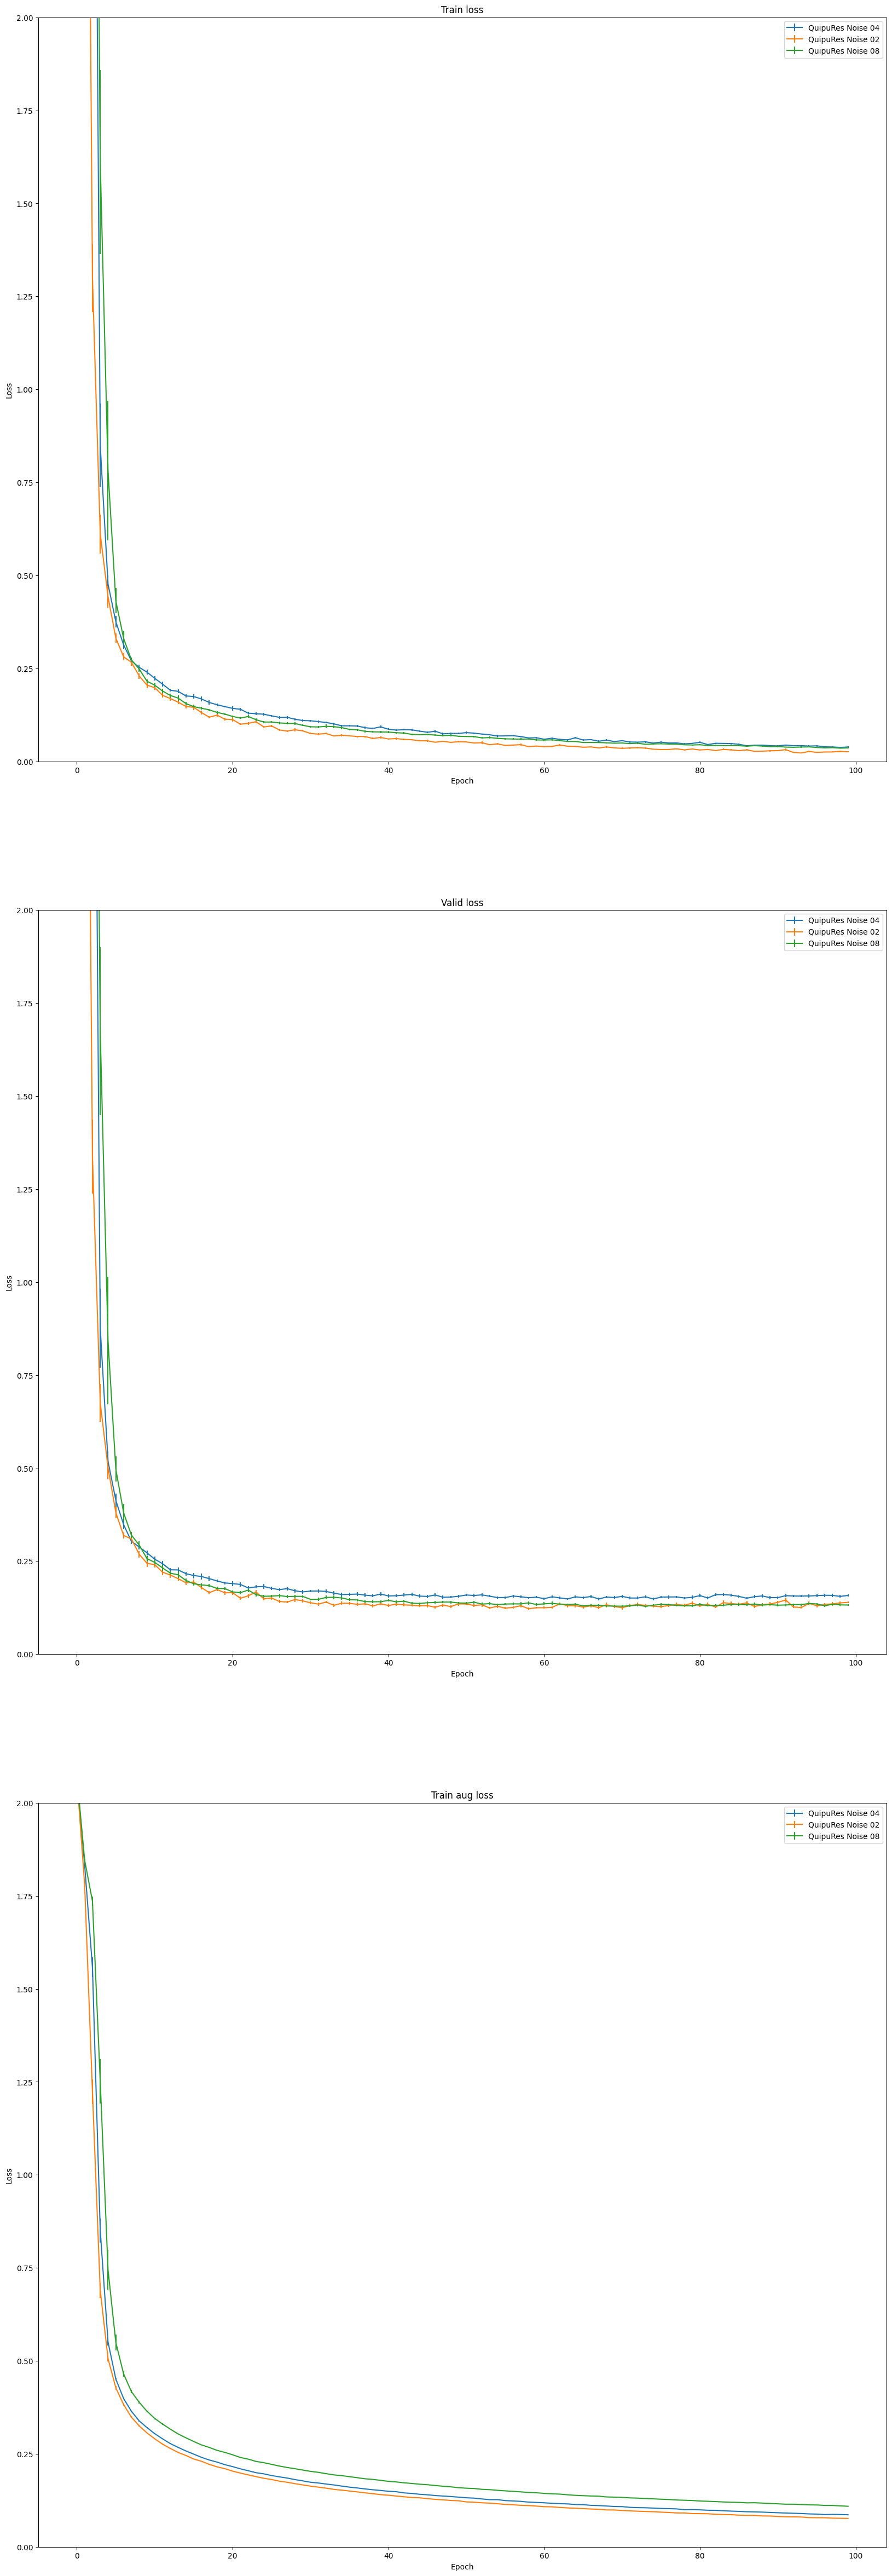

In [9]:
#Noise
df100_QuipuNoise008=get_df(results_newNN_folder,"QuipuRes","20240425_10-26-04_QuipuResAug_log.txt") 
df100_QuipuNoise002=get_df(results_newNN_folder,"QuipuRes","20240425_10-26-19_QuipuResAug_log.txt")
df100_QuipuNoise004=df100_QuipuResBase;
compare_dfs([df100_QuipuNoise004,df100_QuipuNoise002,df100_QuipuNoise008],["QuipuRes Noise 04","QuipuRes Noise 02","QuipuRes Noise 08"])

Seems like less noise added is better already! Maybe the brownian motion aggregates some noise too. Maybe more samples would be better to see even if its better without noise!

------------ Table comparison ----------------
              Name      Train Accuracy      Valid Accuracy  \
0  QuipuRes Str 06  98.31+-0.53(99.20)  96.23+-0.21(96.61)   
1  QuipuRes Str 02  98.30+-0.37(98.79)  96.19+-0.28(96.75)   

        Test Accuracy  nRuns  
0  96.21+-0.31(96.90)     14  
1  96.06+-0.28(96.53)     15  
----------------------------------------------
------------ Plot comparison ----------------


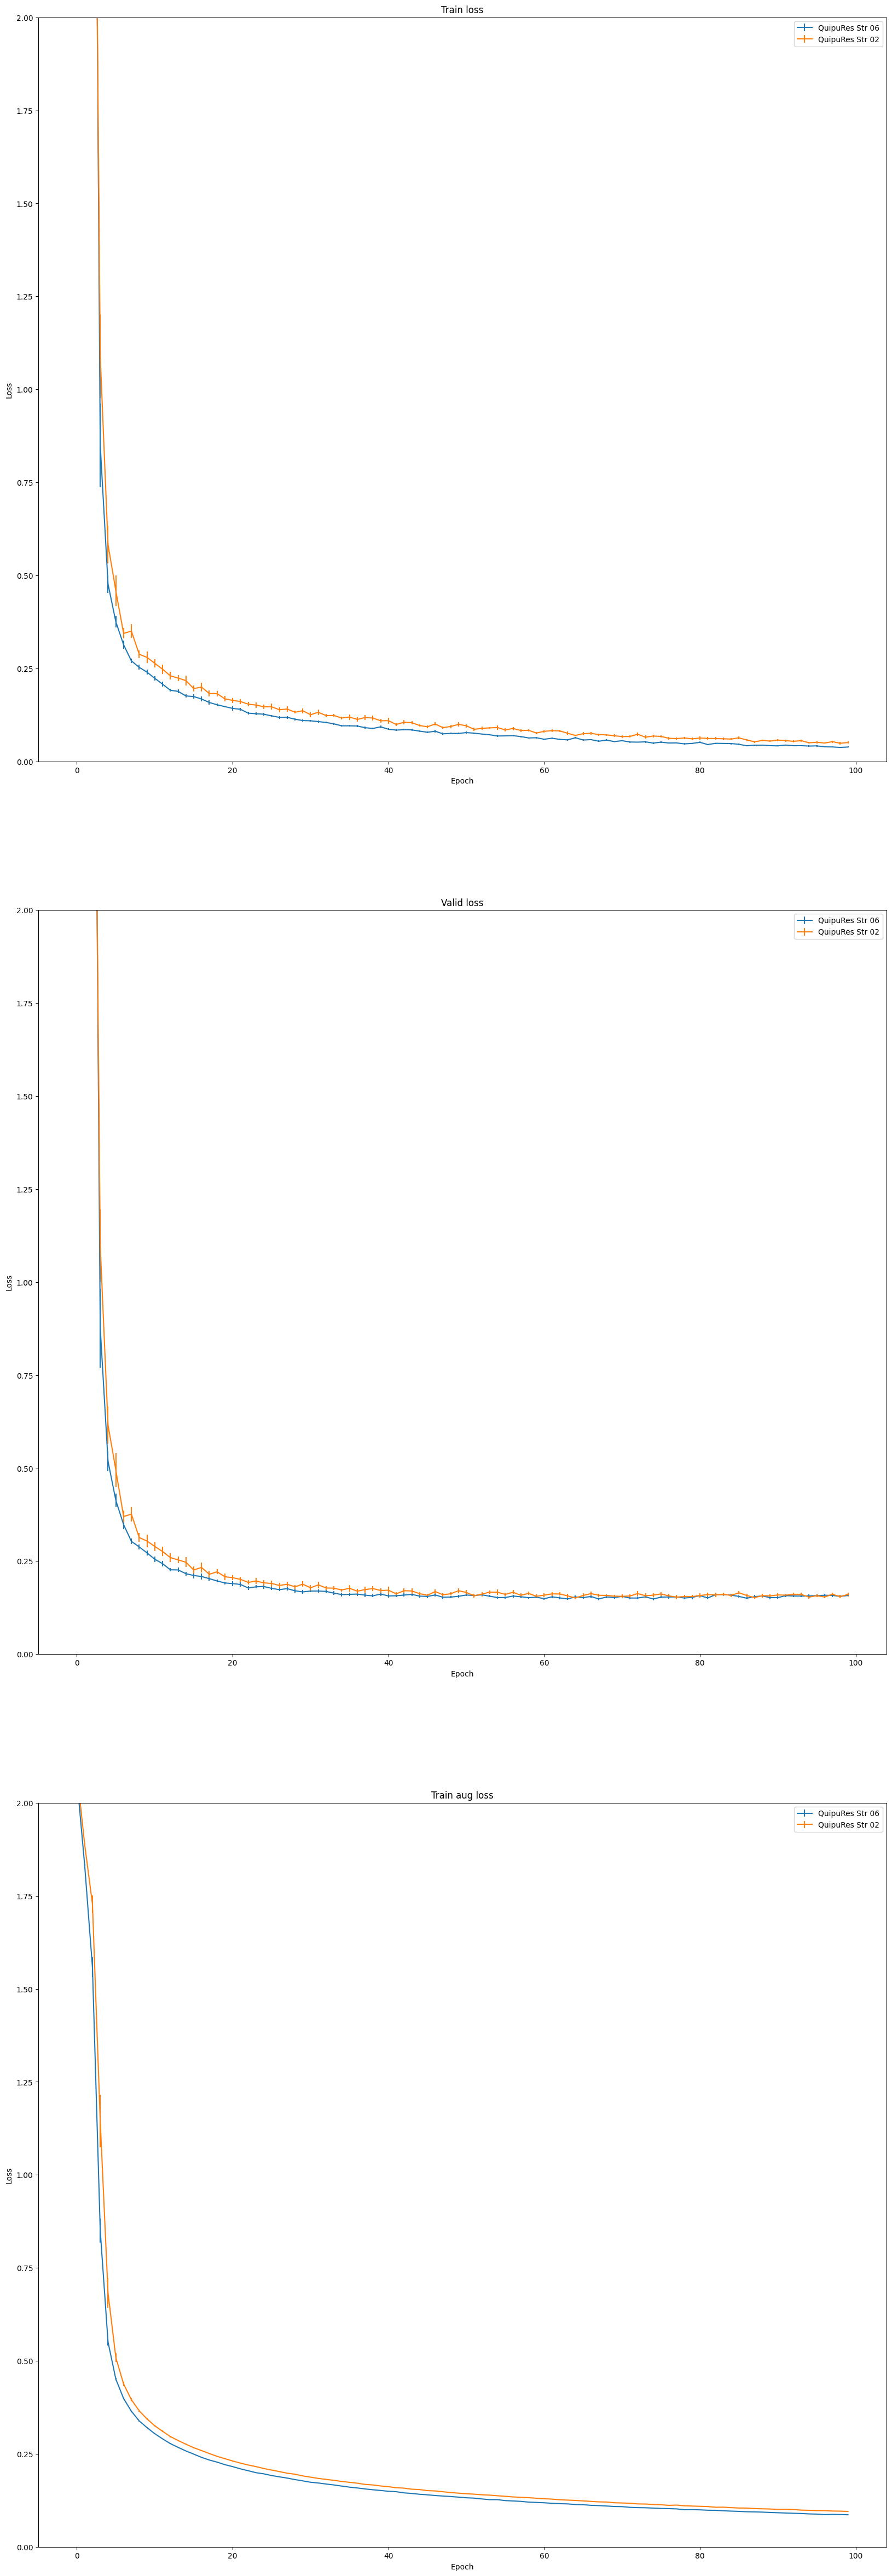

In [10]:
#Stretch
df100_QuipuStr06=get_df(results_newNN_folder,"QuipuRes","20240425_10-30-50_QuipuResAug_log.txt") 

df100_QuipuStr02=df100_QuipuResBase;

compare_dfs([df100_QuipuStr02,df100_QuipuStr06],["QuipuRes Str 06","QuipuRes Str 02"])

Seems to be better more stretch too!

### Changing optimizer
Here we try runnning with SGD, momentum and decay

------------ Table comparison ----------------
                             Name      Train Accuracy      Valid Accuracy  \
0                     Quipu(Brow)  98.51+-0.11(98.73)  96.52+-0.30(97.02)   
1             QuipuBrowSGD LR3E-3  93.18+-0.00(93.18)  92.31+-0.00(92.31)   
2  QuipuBrowSGD LR1E-2 decay 0.96  95.95+-0.61(96.86)  94.83+-0.65(95.66)   
3        QuipuBrowSGD LR1E-2 0.98  96.77+-0.37(97.35)  95.34+-0.43(96.02)   

        Test Accuracy  nRuns  
0  96.38+-0.23(96.71)     15  
1  92.97+-0.00(92.97)      1  
2  94.70+-0.64(95.33)     14  
3  95.42+-0.39(96.06)     13  
----------------------------------------------
------------ Plot comparison ----------------


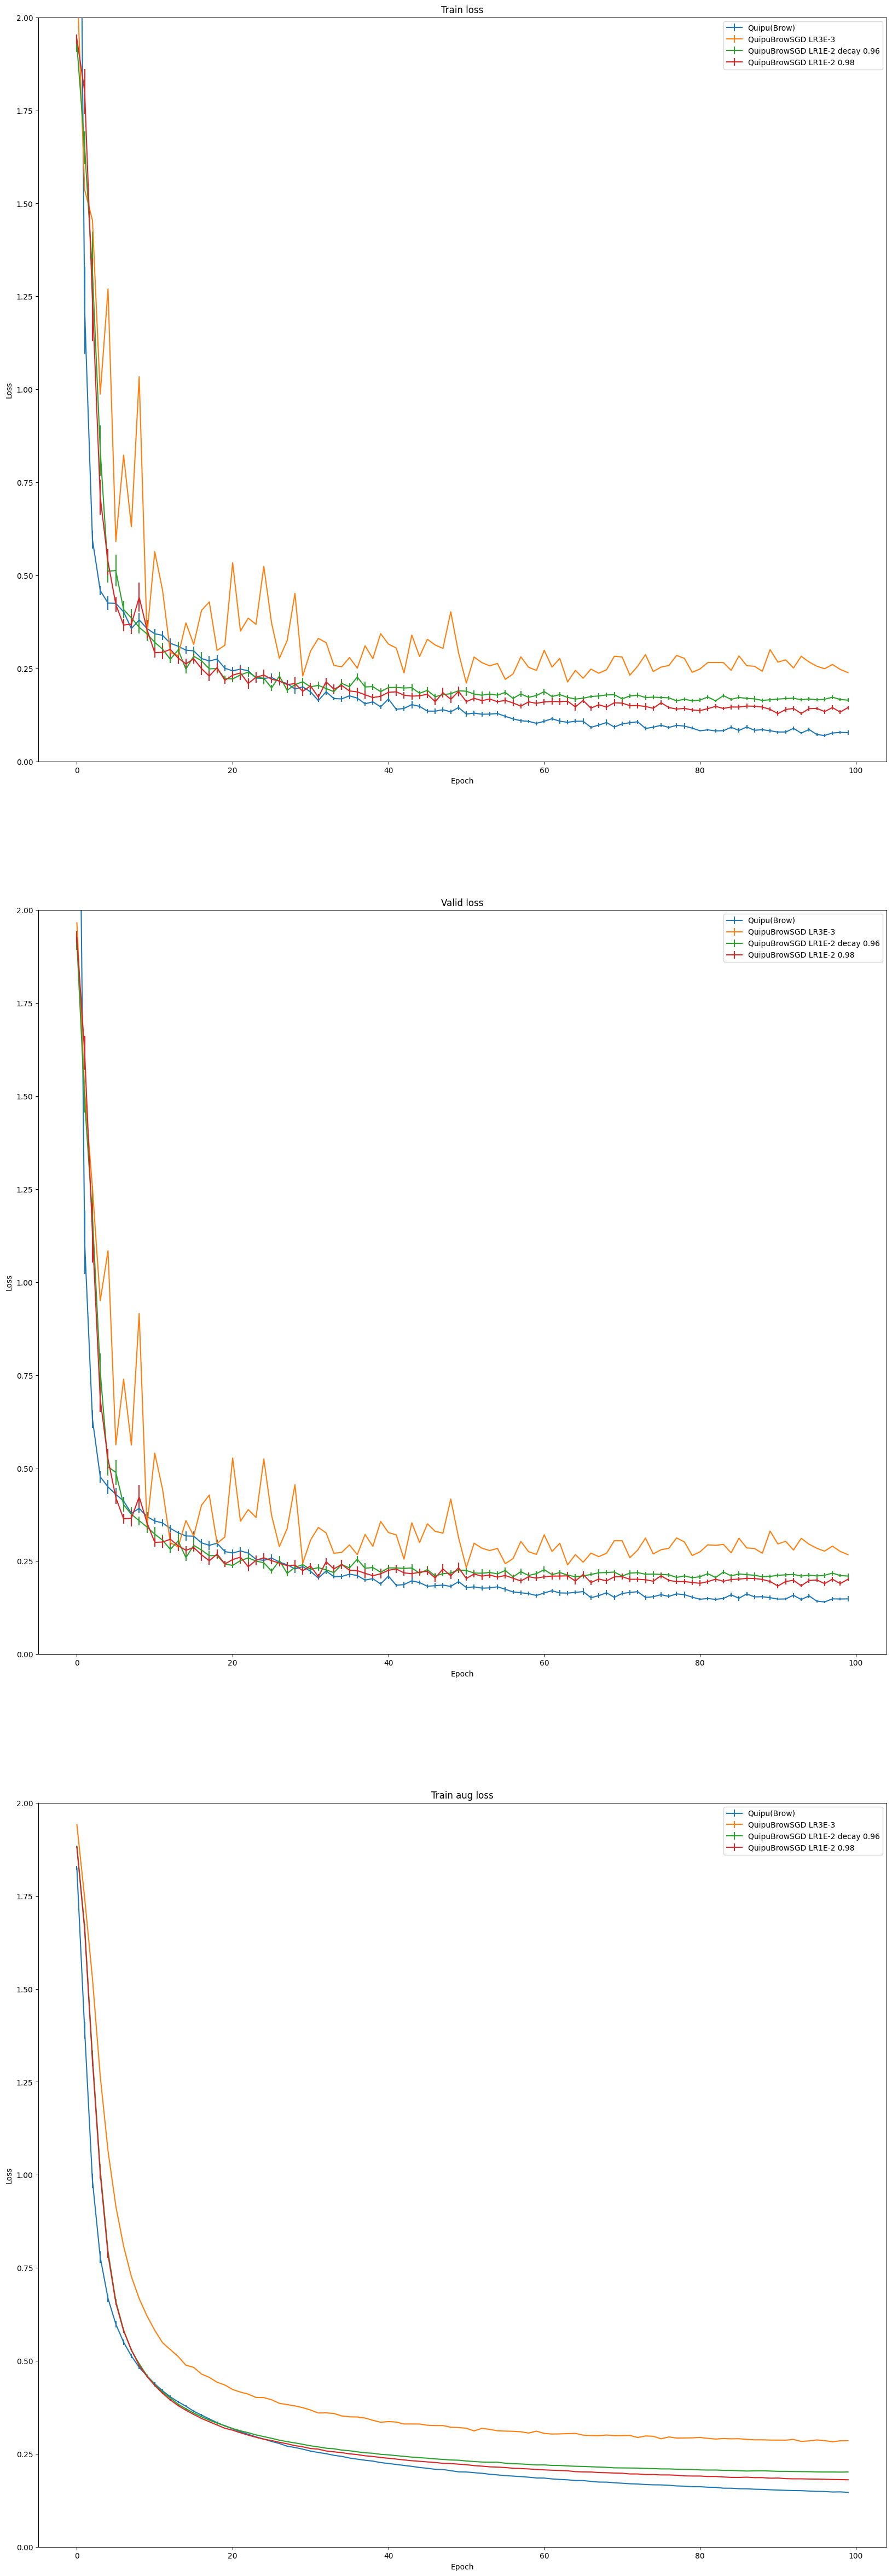

In [12]:
df100_Quipu_SGD=get_df(results_newNN_folder,"Quipu","20240424_17-06-15_QuipuTunTraining_log.txt")# Learning rate 3E-3, decay=0.97
df100_Quipu_SGD2=get_df(results_newNN_folder,"Quipu","20240424_17-30-22_QuipuTunTraining_log.txt")# Learning rate 1E-2, decay=0.97
df100_Quipu_SGD3=get_df(results_newNN_folder,"Quipu","20240425_09-52-29_QuipuTunTraining_log.txt") # 1E-2, decay 0.98

compare_dfs([df100_Quipu,df100_Quipu_SGD,df100_Quipu_SGD2,df100_Quipu_SGD3],["Quipu(Brow)","QuipuBrowSGD LR3E-3","QuipuBrowSGD LR1E-2 decay 0.96","QuipuBrowSGD LR1E-2 0.98"])

Seems hard to tune SGD correctly, and adam ends up doing a better job. Also couldnt see much better validation accuracy due to sgd.

# Results on final test dataset

------------ Table comparison ----------------
           Name      Train Accuracy      Valid Accuracy       Test Accuracy  \
0         Quipu  99.11+-0.24(99.44)  96.79+-0.17(96.97)  93.99+-0.58(94.46)   
1     QuipuBrow  98.37+-0.20(98.77)  96.45+-0.32(97.11)  93.86+-0.36(94.34)   
2      QuipuExt  98.73+-0.29(99.28)  96.71+-0.29(97.46)  93.87+-0.39(94.66)   
3  QuipuExtBrow  98.92+-0.23(99.24)  96.84+-0.28(97.35)  93.90+-0.39(94.69)   

   nRuns  
0      9  
1     18  
2     18  
3     18  
----------------------------------------------
------------ Plot comparison ----------------


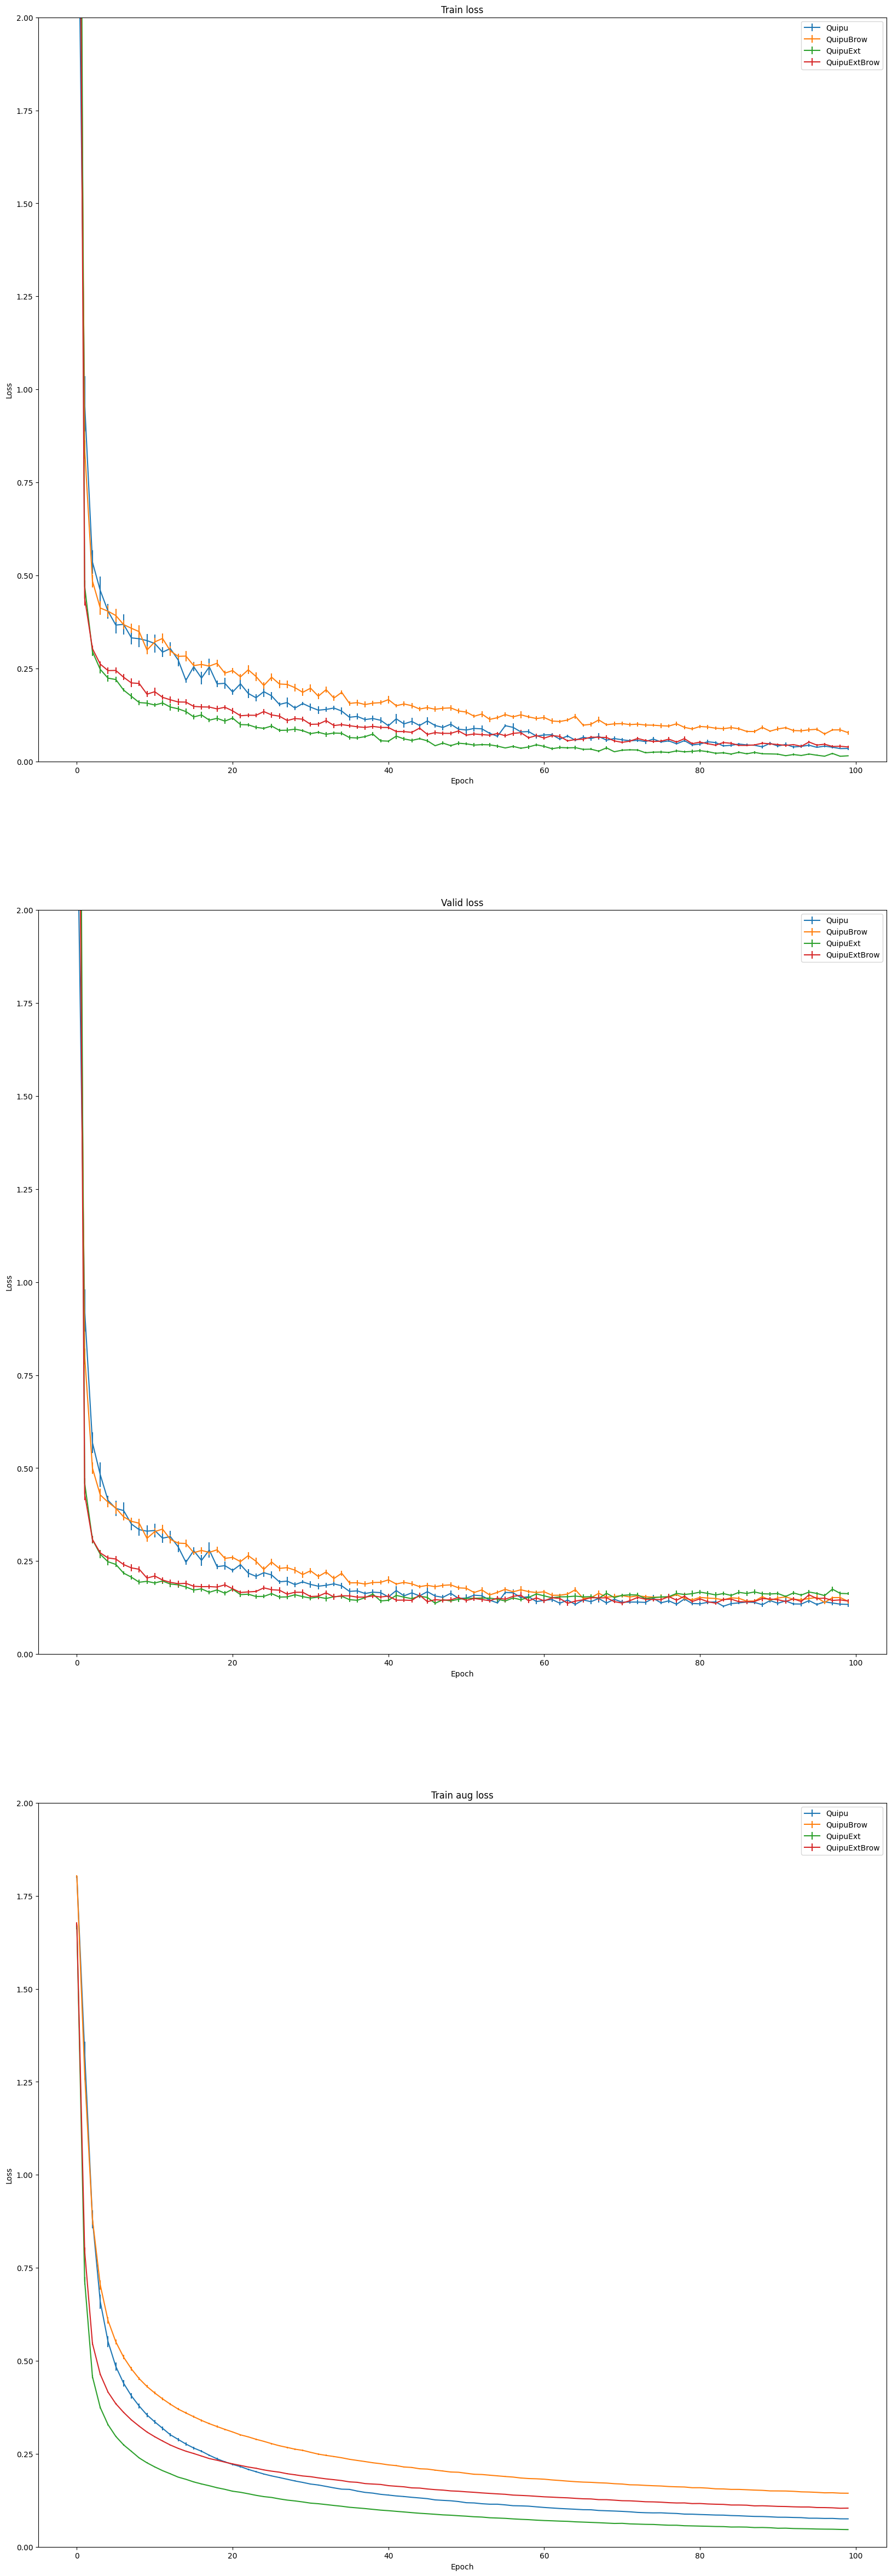

In [5]:
folder_quipu,file_QuipuFinalBrow=get_folder_and_filepath(results_newNN_folder,"Quipu","20240419_12-11-14_QuipuFinalBrow_log.txt")
_,file_QuipuFinalBrow2=get_folder_and_filepath(results_newNN_folder,"Quipu","20240421_19-50-42_QuipuFinalBrow_log.txt")
df_extra=get_runs_of_experiment(file_QuipuFinalBrow2,folder_quipu)
df_QuipuBrowFinal=get_runs_of_experiment(file_QuipuFinalBrow,folder_quipu)
df_QuipuBrowFinal=pd.concat([df_QuipuBrowFinal,df_extra]);

folder_quipu,file_QuipuFinal=get_folder_and_filepath(results_newNN_folder,"Quipu","20240419_12-12-25_QuipuFinalNoBrow_log.txt")
df_QuipuFinal=get_runs_of_experiment(file_QuipuFinal,folder_quipu)

#Multiple runs because they crashed at 10 trainings!
folder_quipu,file_QuipuExtFinalBrow=get_folder_and_filepath(results_newNN_folder,"Quipu","20240419_15-28-23_QuipuExtBrowFinal_log.txt")
_,file_QuipuExtFinalBrow2=get_folder_and_filepath(results_newNN_folder,"Quipu","20240421_19-49-01_QuipuExtBrowFinal_log.txt")
df_extra=get_runs_of_experiment(file_QuipuExtFinalBrow2,folder_quipu)
df_QuipuExtFinalBrow=get_runs_of_experiment(file_QuipuExtFinalBrow,folder_quipu)
df_QuipuExtFinalBrow=pd.concat([df_QuipuExtFinalBrow,df_extra]);

folder_quipu,file_QuipuExtFinal=get_folder_and_filepath(results_newNN_folder,"Quipu","20240419_15-28-23_QuipuExtFinal_log.txt")
_,file_QuipuExtFinal2=get_folder_and_filepath(results_newNN_folder,"Quipu","20240421_19-48-59_QuipuExtFinal_log.txt")
df_extra=get_runs_of_experiment(file_QuipuExtFinal2,folder_quipu)
df_QuipuExtFinal=get_runs_of_experiment(file_QuipuExtFinal,folder_quipu)
df_QuipuExtFinal=pd.concat([df_QuipuExtFinal,df_extra]);

compare_dfs([df_QuipuFinal,df_QuipuBrowFinal,df_QuipuExtFinal,df_QuipuExtFinalBrow],["Quipu","QuipuBrow","QuipuExt","QuipuExtBrow"])

------------ Table comparison ----------------
           Name      Train Accuracy      Valid Accuracy       Test Accuracy  \
0     QuipuBrow  98.37+-0.20(98.77)  96.45+-0.32(97.11)  93.86+-0.36(94.34)   
1  QuipuExtBrow  98.92+-0.23(99.24)  96.84+-0.28(97.35)  93.90+-0.39(94.69)   
2      QuipuRes  98.67+-0.18(98.96)  96.61+-0.25(97.17)  93.80+-0.31(94.43)   

   nRuns  
0     18  
1     18  
2     11  
----------------------------------------------
------------ Plot comparison ----------------


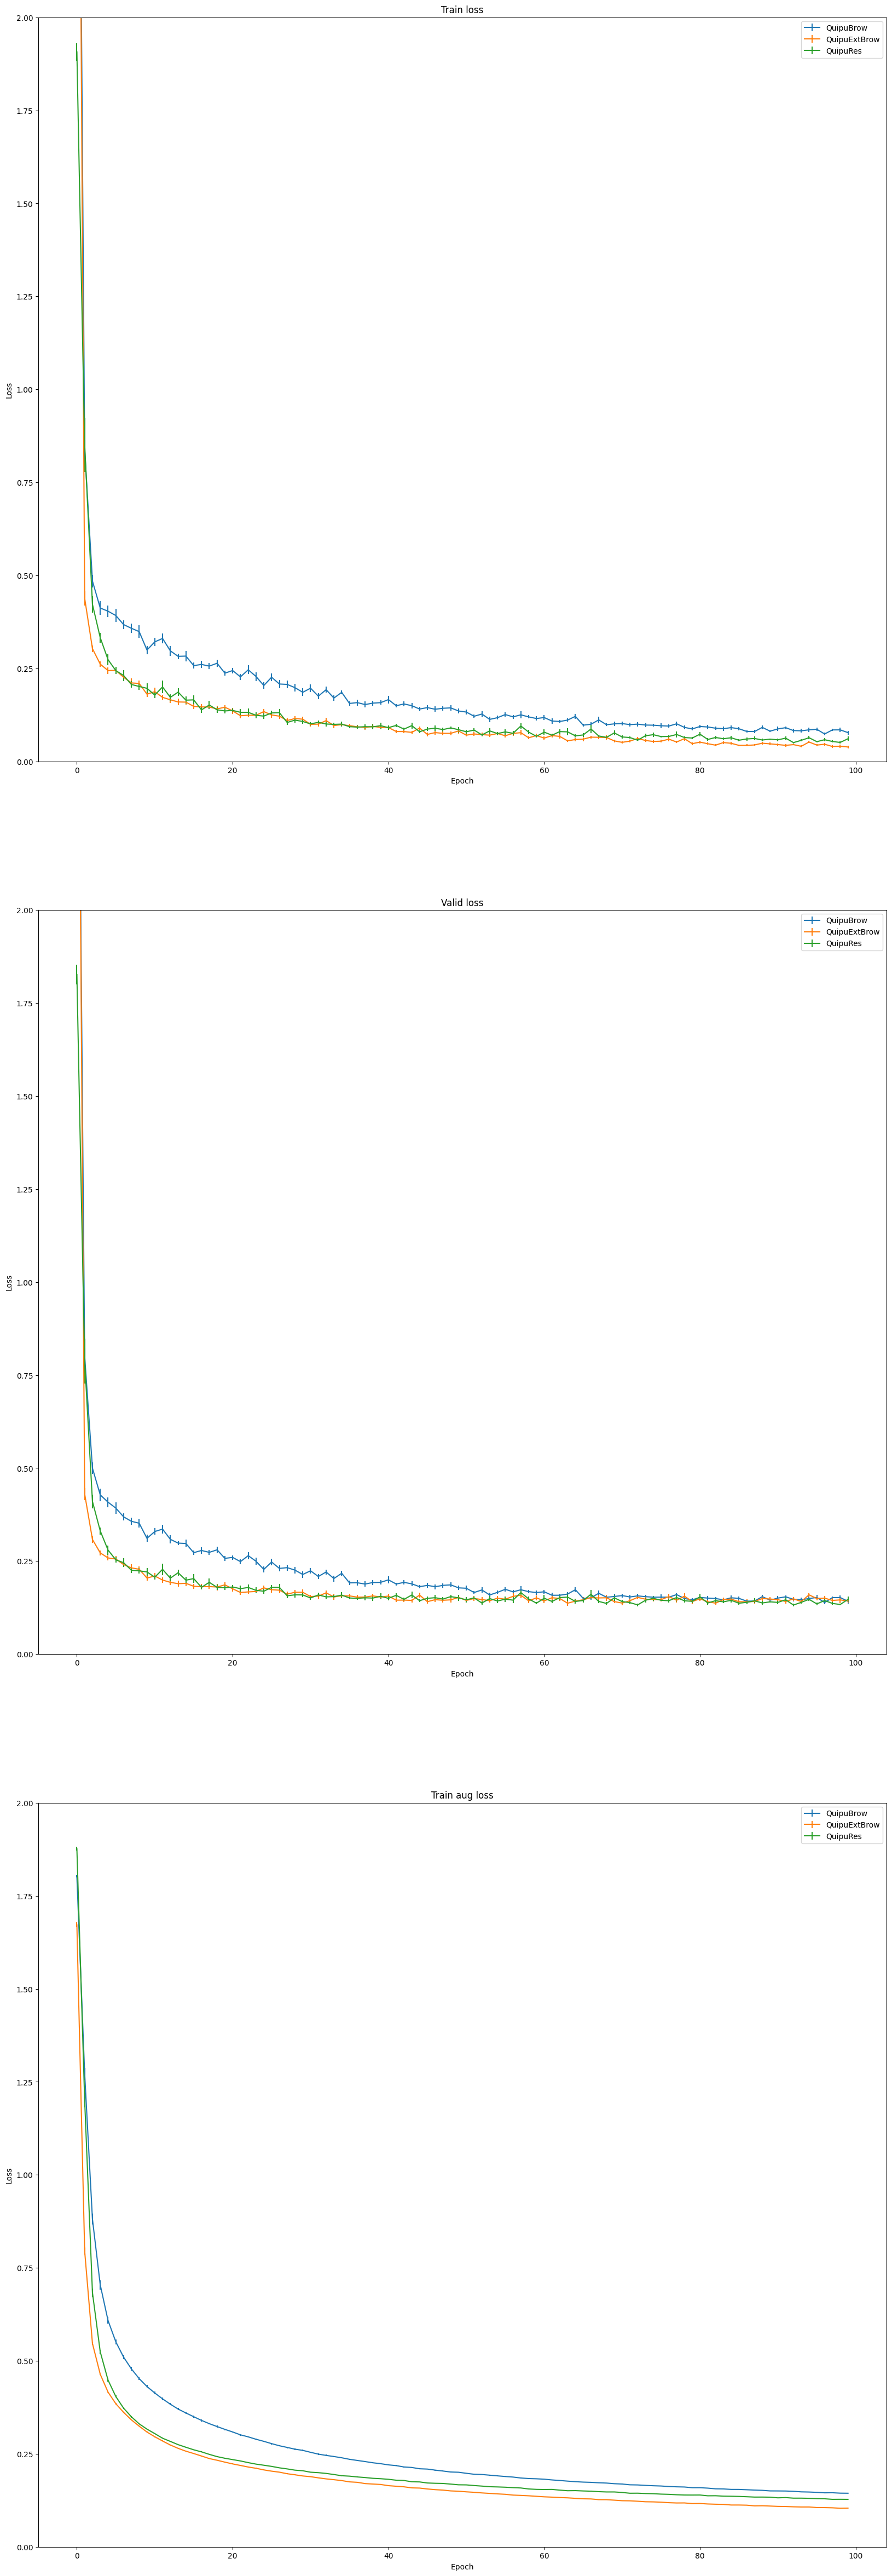

In [6]:
folder_quipuModif,file_QuipuResFinal=get_folder_and_filepath(results_newNN_folder,"QuipuModif","20240422_10-57-55_QuipuResFinal_log.txt")
df_QuipuResFinal=get_runs_of_experiment(file_QuipuResFinal,folder_quipuModif)
compare_dfs([df_QuipuBrowFinal,df_QuipuExtFinalBrow,df_QuipuResFinal],["QuipuBrow","QuipuExtBrow","QuipuRes"])

Now I have changed a few values in the augmentation due to the curves obtained, and trying with different learning rates with the QuipuResV2. Lets see what we get (Quipu also run with new parameters of augmentation). Also Validation dataset reduced to half which I expect to make test acc more spread but maybe reaching higher values!.

------------ Table comparison ----------------
                   Name      Train Accuracy      Valid Accuracy  \
0       Quipu as before  99.11+-0.24(99.44)  96.79+-0.17(96.97)   
1  Quipu Low Validation  98.48+-0.17(98.75)  96.68+-0.33(97.37)   
2          QRv2 LR=1E-4  98.94+-0.37(99.46)  96.80+-0.48(97.48)   
3          QRv2 LR=3E-5  98.59+-0.08(98.71)  96.67+-0.28(97.12)   
4          QRv2 LR=2E-4  98.98+-0.39(99.47)  96.90+-0.32(97.33)   

        Test Accuracy  nRuns  
0  93.99+-0.58(94.46)      9  
1  94.44+-0.28(94.77)     16  
2  94.80+-0.44(95.24)     12  
3  94.02+-0.53(94.98)     12  
4  94.86+-0.47(95.76)     12  
----------------------------------------------
------------ Plot comparison ----------------


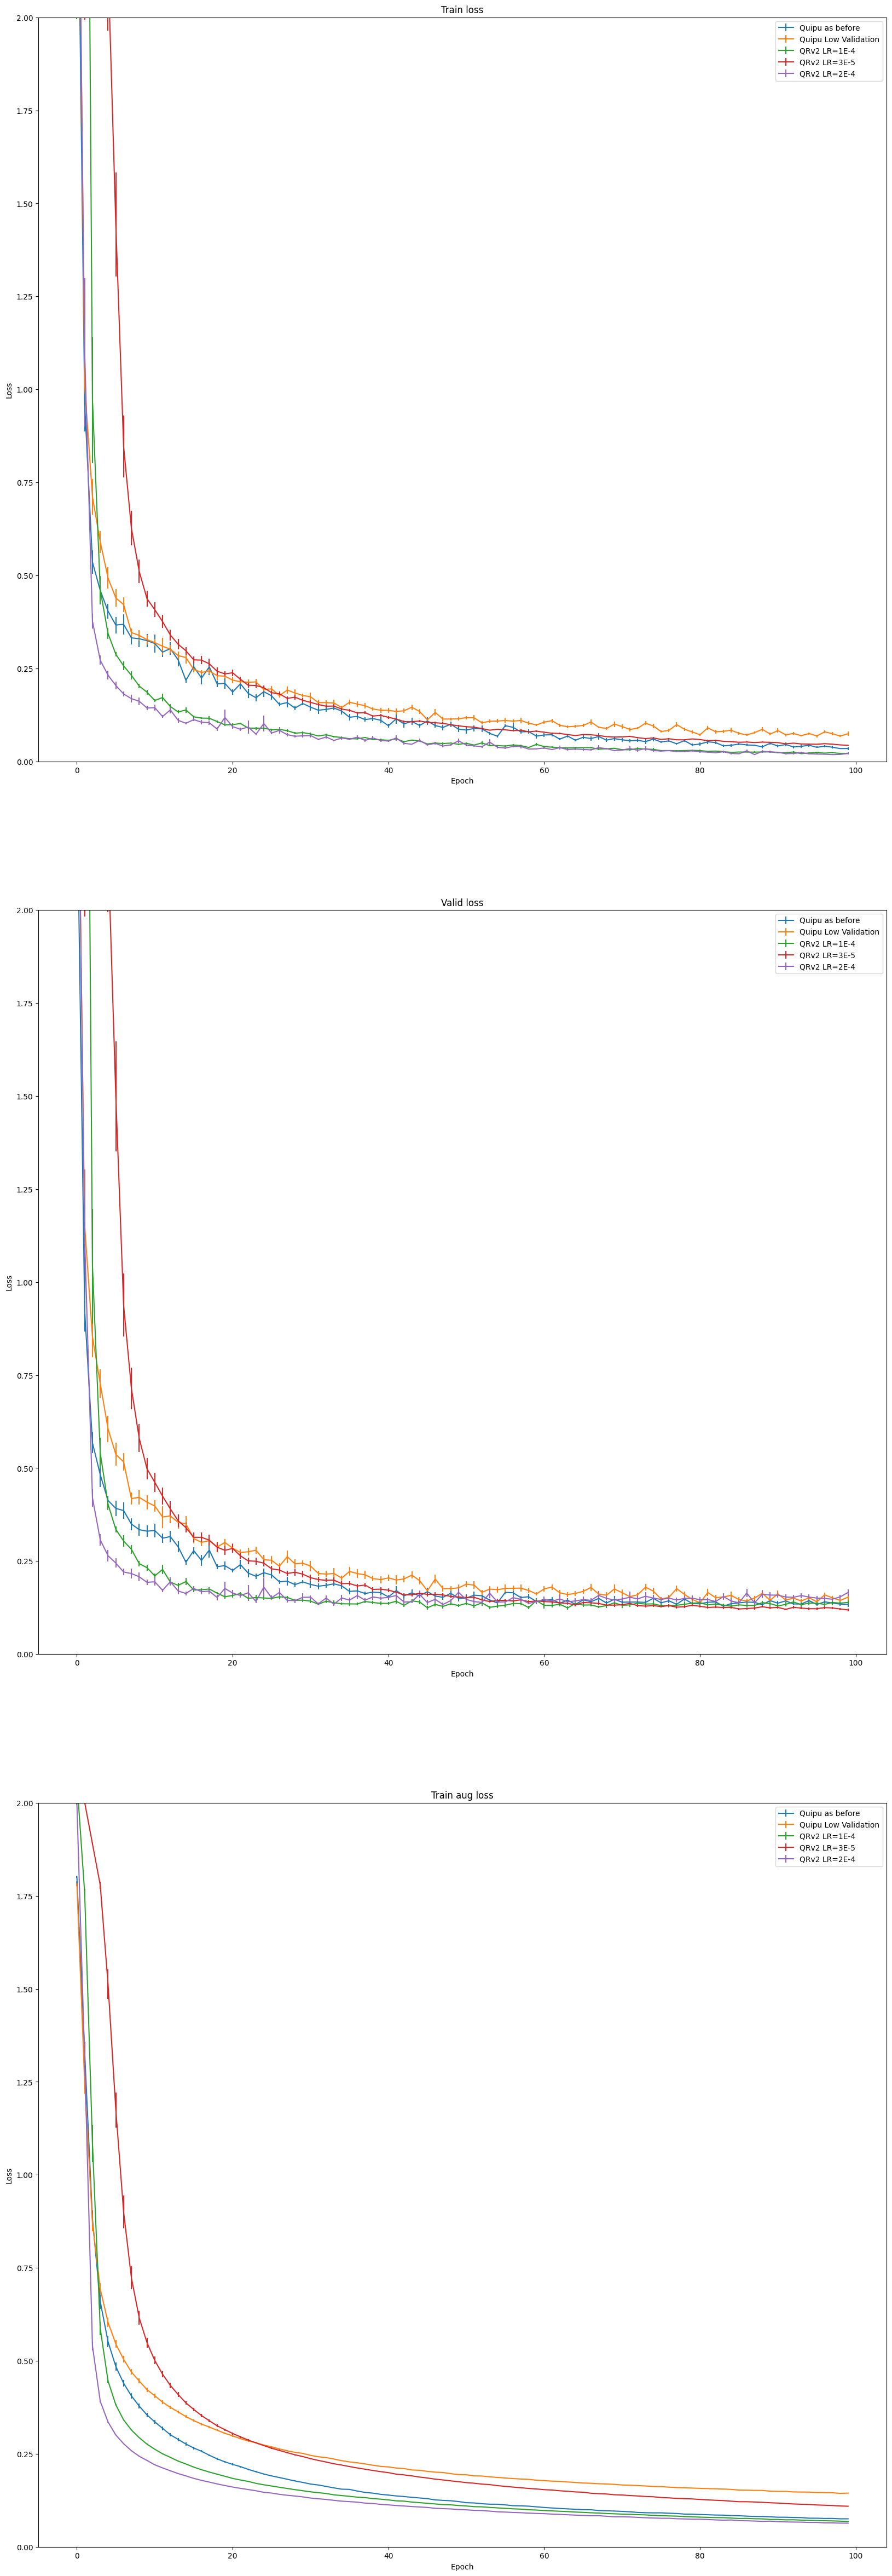

In [7]:
df_Quipu_new=get_df(results_newNN_folder,"Quipu","20240426_11-04-50_QuipuBrowLowV_log.txt") 
df_QuipuRes_new_lr1e4=get_df(results_newNN_folder,"QuipuRes","20240426_11-08-53_QuipuResLowV_log.txt") 
df_QuipuRes_new_lr3e5=get_df(results_newNN_folder,"QuipuRes","20240426_11-14-03_QuipuResLowV_log.txt") 
df_QuipuRes_new_lr2e4=get_df(results_newNN_folder,"QuipuRes","20240426_12-47-29_QuipuResLowV_log.txt")
compare_dfs([df_QuipuFinal,df_Quipu_new,df_QuipuRes_new_lr1e4,df_QuipuRes_new_lr3e5,df_QuipuRes_new_lr2e4],["Quipu as before","Quipu Low Validation","QRv2 LR=1E-4","QRv2 LR=3E-5","QRv2 LR=2E-4"])

------------ Table comparison ----------------
              Name      Train Accuracy      Valid Accuracy  \
0  Quipu as before  99.11+-0.24(99.44)  96.79+-0.17(96.97)   
1   Best quipu res  98.98+-0.39(99.47)  96.90+-0.32(97.33)   
2       QRv2 swish  99.07+-0.21(99.52)  96.81+-0.25(97.19)   
3        QRA swish  98.74+-0.50(99.36)  96.70+-0.46(97.19)   
4         QRA relu  99.01+-0.26(99.46)  96.82+-0.33(97.37)   

        Test Accuracy  nRuns  
0  93.99+-0.58(94.46)      9  
1  94.86+-0.47(95.76)     12  
2  94.64+-0.27(95.18)     10  
3  94.45+-0.59(95.09)      8  
4  95.10+-0.48(95.76)      9  
----------------------------------------------
------------ Plot comparison ----------------


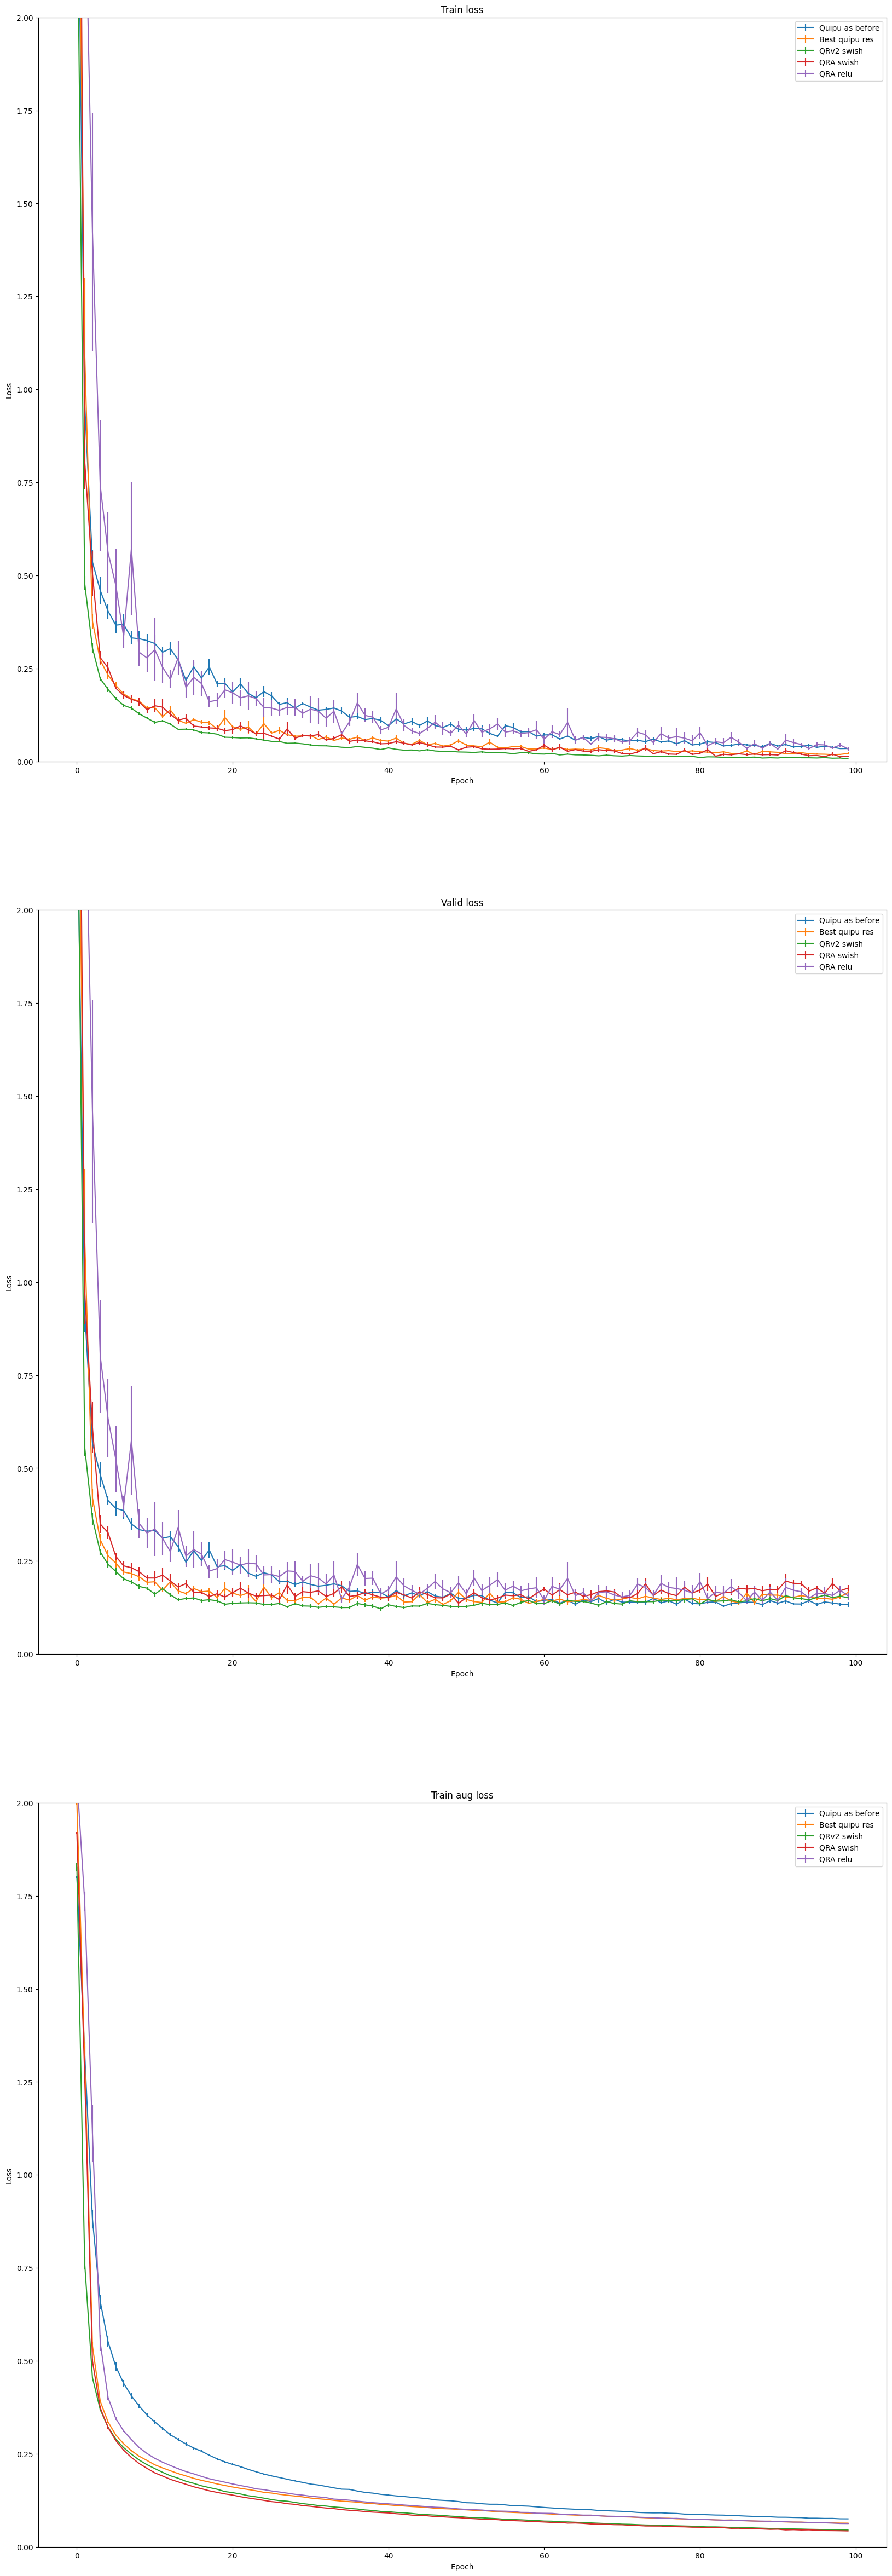

In [8]:

df_QuipuRes_new_swish=get_df(results_newNN_folder,"QuipuRes","20240426_12-51-40_QuipuResLowV_log.txt") # LR 1E-4, using swish act
df_QuipuResAtt_swish=get_df(results_newNN_folder,"QuipuRes","20240426_13-06-09_QuipuResAttLowV_log.txt") # LR 1E-4, using swish act and Attention layer
df_QuipuResAtt_relu=get_df(results_newNN_folder,"QuipuRes","20240426_13-12-31_QuipuResAttLowV_log.txt") #Attention with relu act

compare_dfs([df_QuipuFinal,df_QuipuRes_new_lr2e4,df_QuipuRes_new_swish,df_QuipuResAtt_swish,df_QuipuResAtt_relu ],["Quipu as before","Best quipu res","QRv2 swish","QRA swish","QRA relu"])

------------ Table comparison ----------------
                      Name      Train Accuracy      Valid Accuracy  \
0          Quipu as before  99.11+-0.24(99.44)  96.79+-0.17(96.97)   
1                      QRA  99.01+-0.26(99.46)  96.82+-0.33(97.37)   
2              QRA LR=2E-4  98.85+-0.36(99.42)  97.05+-0.33(97.41)   
3  QRA more dense 2LR=2E-4  98.84+-0.32(99.19)  96.76+-0.33(97.23)   

        Test Accuracy  nRuns  
0  93.99+-0.58(94.46)      9  
1  95.10+-0.48(95.76)      9  
2  94.86+-0.56(95.99)     11  
3  94.93+-0.43(95.35)     11  
----------------------------------------------
------------ Plot comparison ----------------


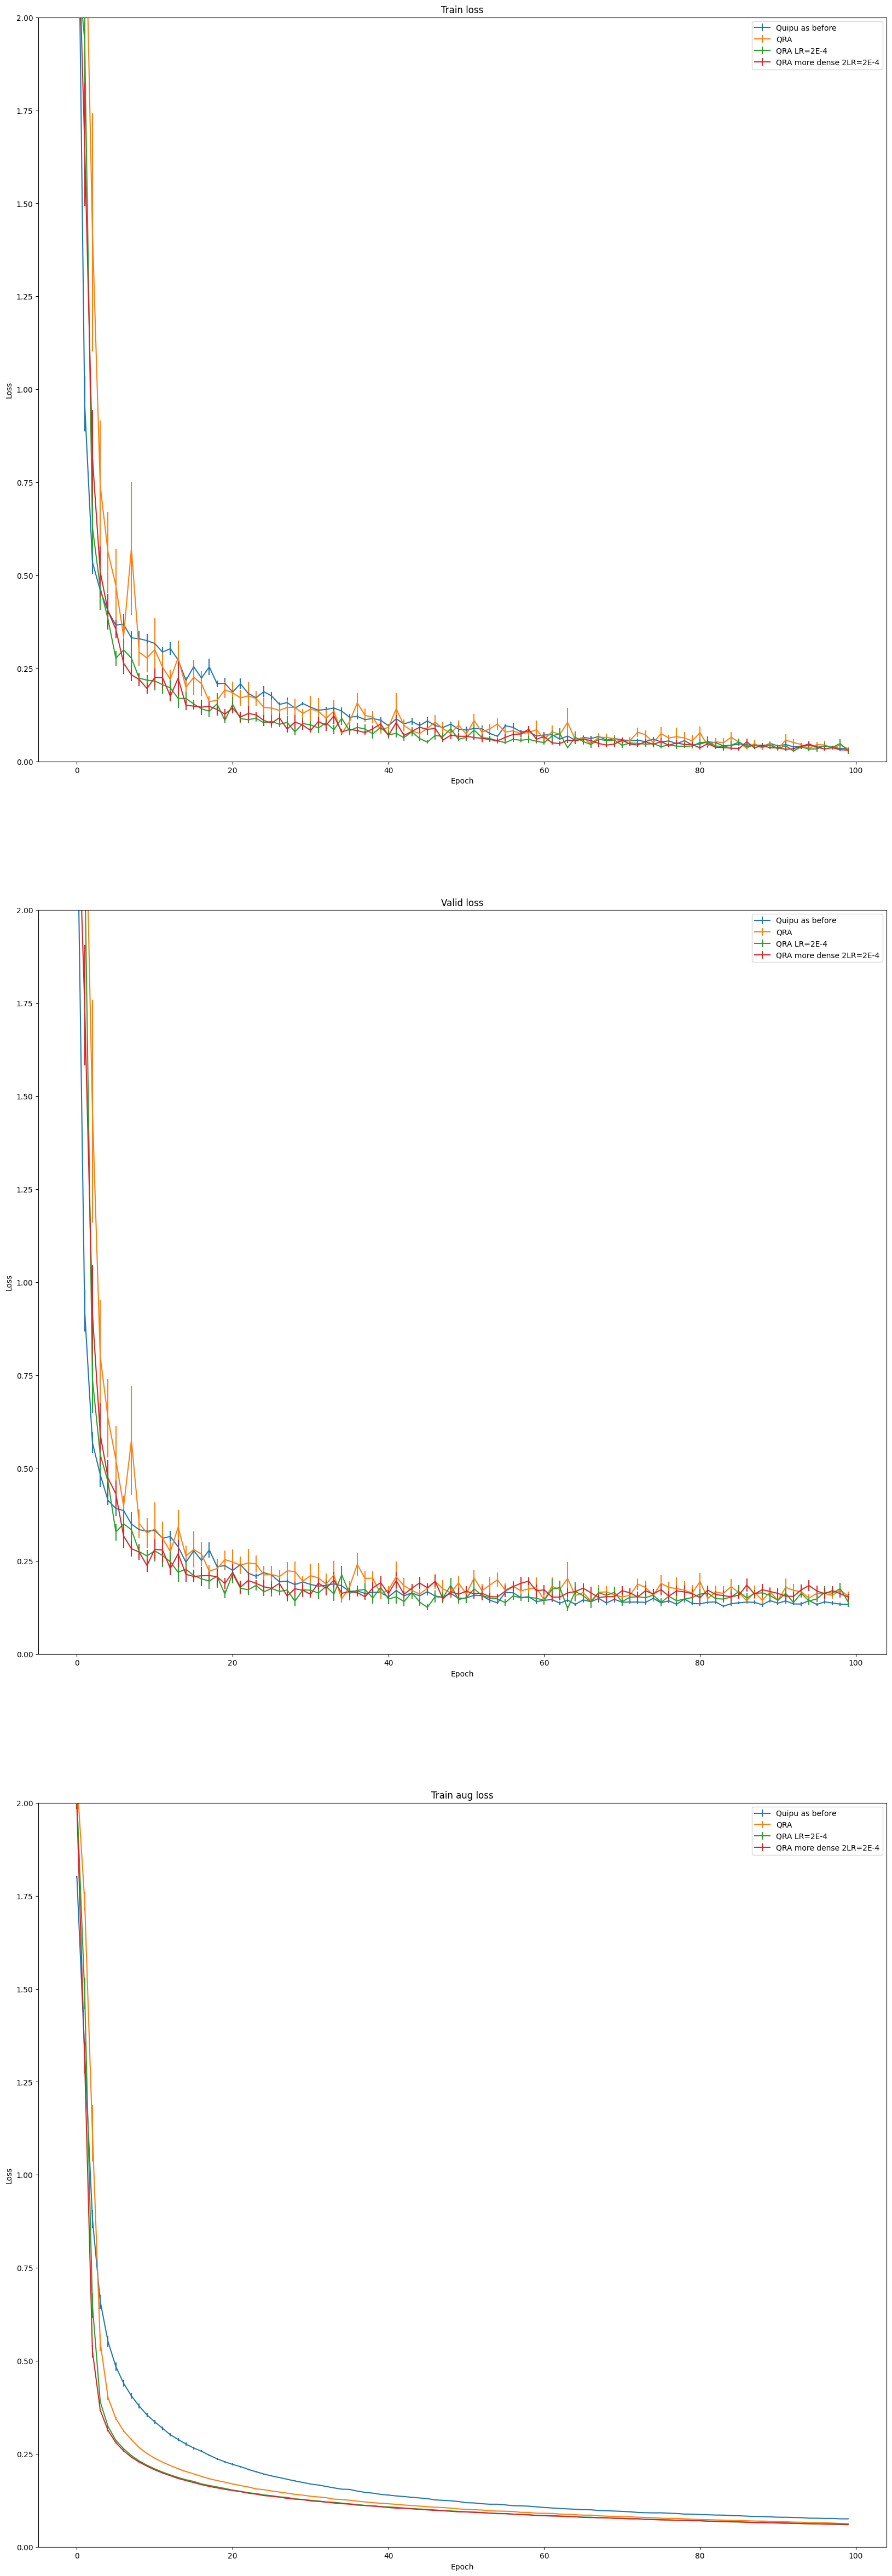

In [9]:
df_QuipuResAttLR2e4=get_df(results_newNN_folder,"QuipuRes","20240429_10-22-51_QuipuResAttLowV_log.txt") #lr: 0.0002 attention
df_QuipuResAttLR2e4dense2_1024=get_df(results_newNN_folder,"QuipuRes","20240429_10-32-20_QuipuResAttLowV_log.txt") #lr: 0.0002 attention

compare_dfs([df_QuipuFinal,df_QuipuResAtt_relu,df_QuipuResAttLR2e4,df_QuipuResAttLR2e4dense2_1024],["Quipu as before","QRA","QRA LR=2E-4","QRA more dense 2LR=2E-4"])

------------ Table comparison ----------------
     Name      Train Accuracy      Valid Accuracy       Test Accuracy  nRuns
0  LR 1E4  98.91+-0.25(99.36)  96.84+-0.53(97.77)  94.93+-0.37(95.70)     33
1  LR 2E4  98.89+-0.41(99.52)  96.90+-0.40(97.92)  94.95+-0.42(95.84)     47
2  LR 5E4  98.85+-0.45(99.37)  96.76+-0.41(97.19)  95.02+-0.46(95.79)     11
----------------------------------------------
------------ Plot comparison ----------------


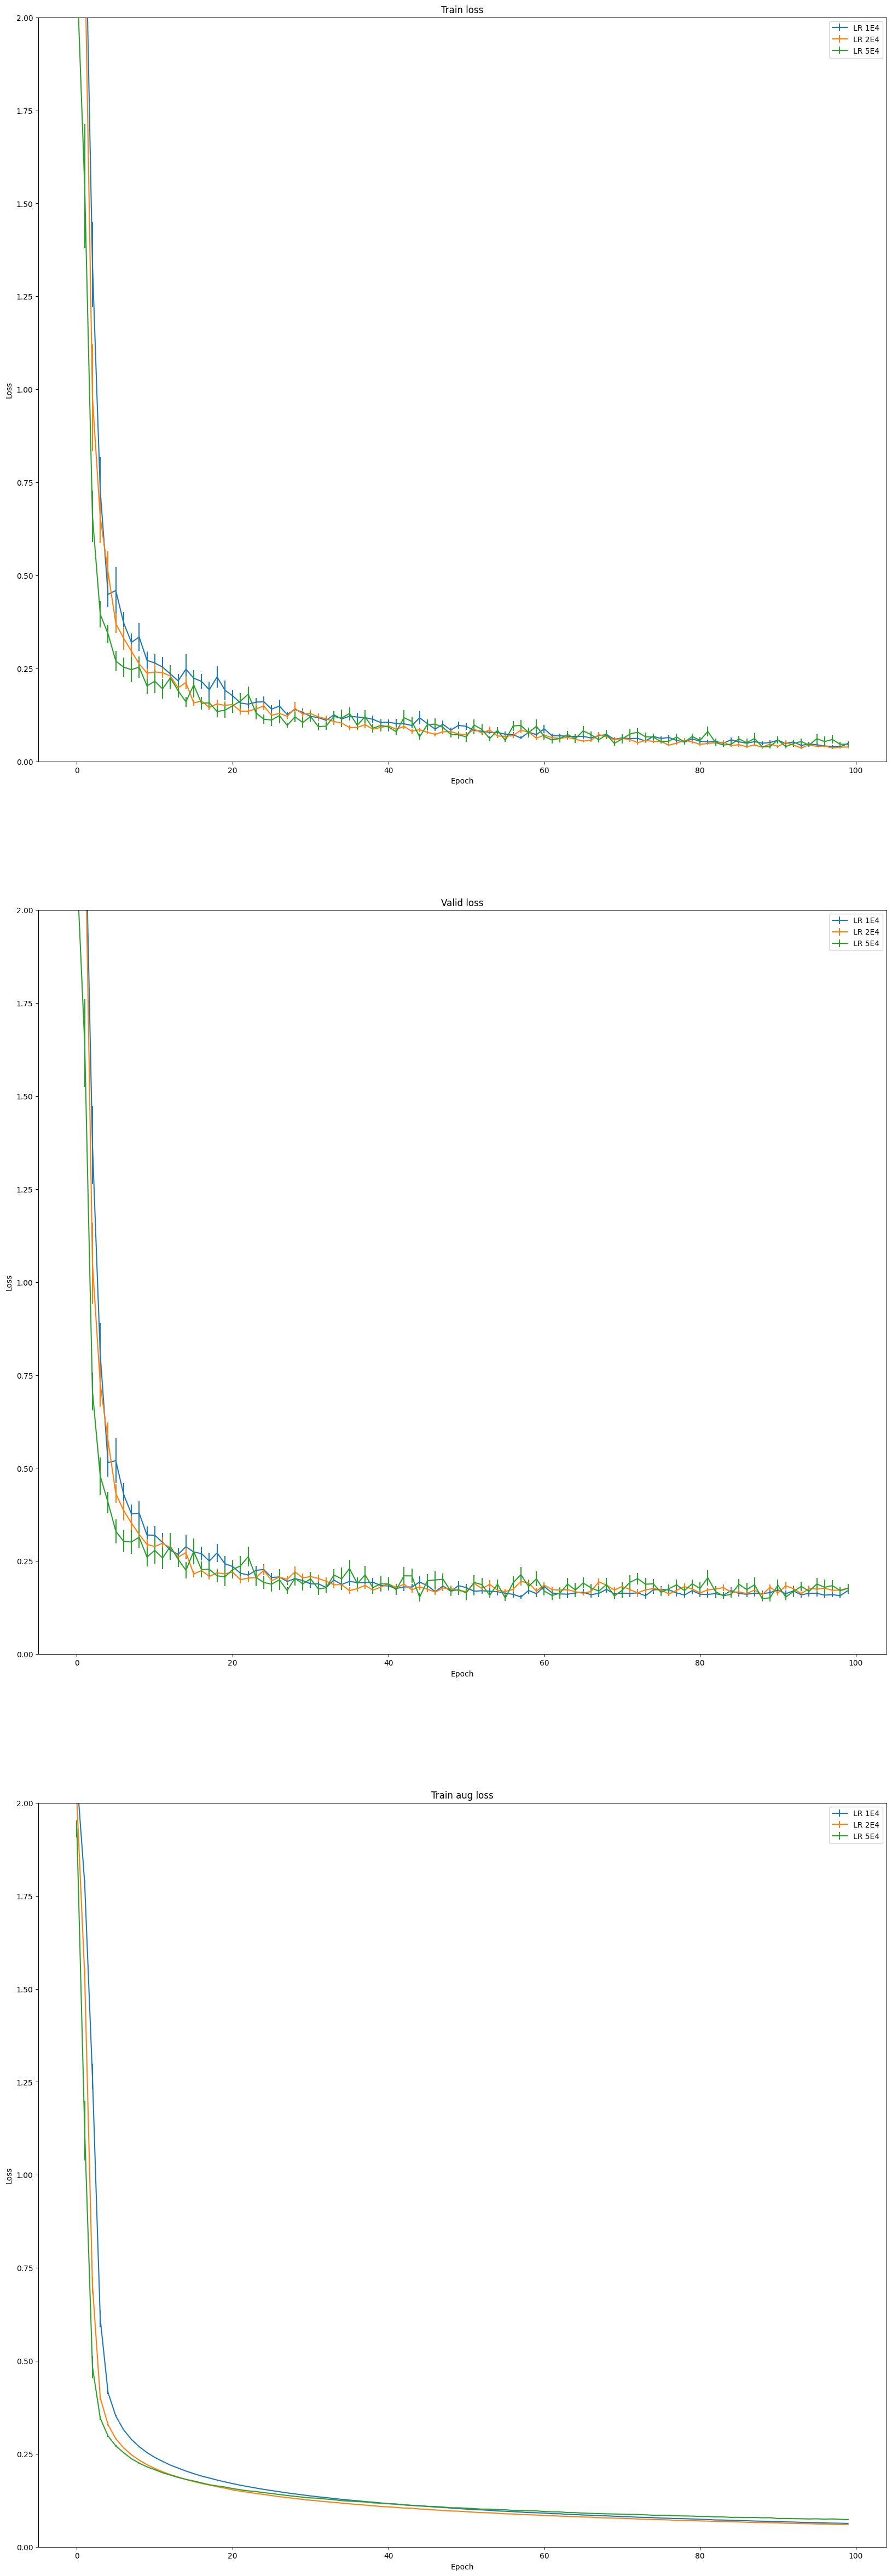

In [5]:
final_lr1e4=load_multiple_files(results_newNN_folder,"Ablation",["20240503_11-42-14_FinalLR1E4_log.txt", "20240503_11-43-30_FinalLR1E4_log.txt", "20240503_11-43-50_FinalLR1E4_log.txt"])
final_lr2e4=load_multiple_files(results_newNN_folder,"Ablation",["20240503_11-51-02_FinalLR2E4_log.txt", "20240503_12-05-49_FinalLR2E4_log.txt", "20240503_13-10-14_FinalLR2E4_log.txt","20240506_14-50-01_FinalLR2E4_log.txt"])
final_lr5e4=get_df(results_newNN_folder,"Ablation","20240503_16-13-15_FinalLR5E4_log.txt") 


compare_dfs([final_lr1e4,final_lr2e4,final_lr5e4],["LR 1E4","LR 2E4","LR 5E4"])

------------ Table comparison ----------------
                 Name      Train Accuracy      Valid Accuracy  \
0       Removing Brow  98.98+-0.36(99.61)  96.98+-0.32(97.48)   
1  Removing attention  98.88+-0.27(99.55)  96.81+-0.33(97.30)   
2       Removing both  98.80+-0.43(99.38)  96.80+-0.44(97.44)   

        Test Accuracy  nRuns  
0  94.57+-0.45(95.24)     22  
1  94.79+-0.34(95.41)     29  
2  94.44+-0.29(94.95)     14  
----------------------------------------------
------------ Plot comparison ----------------


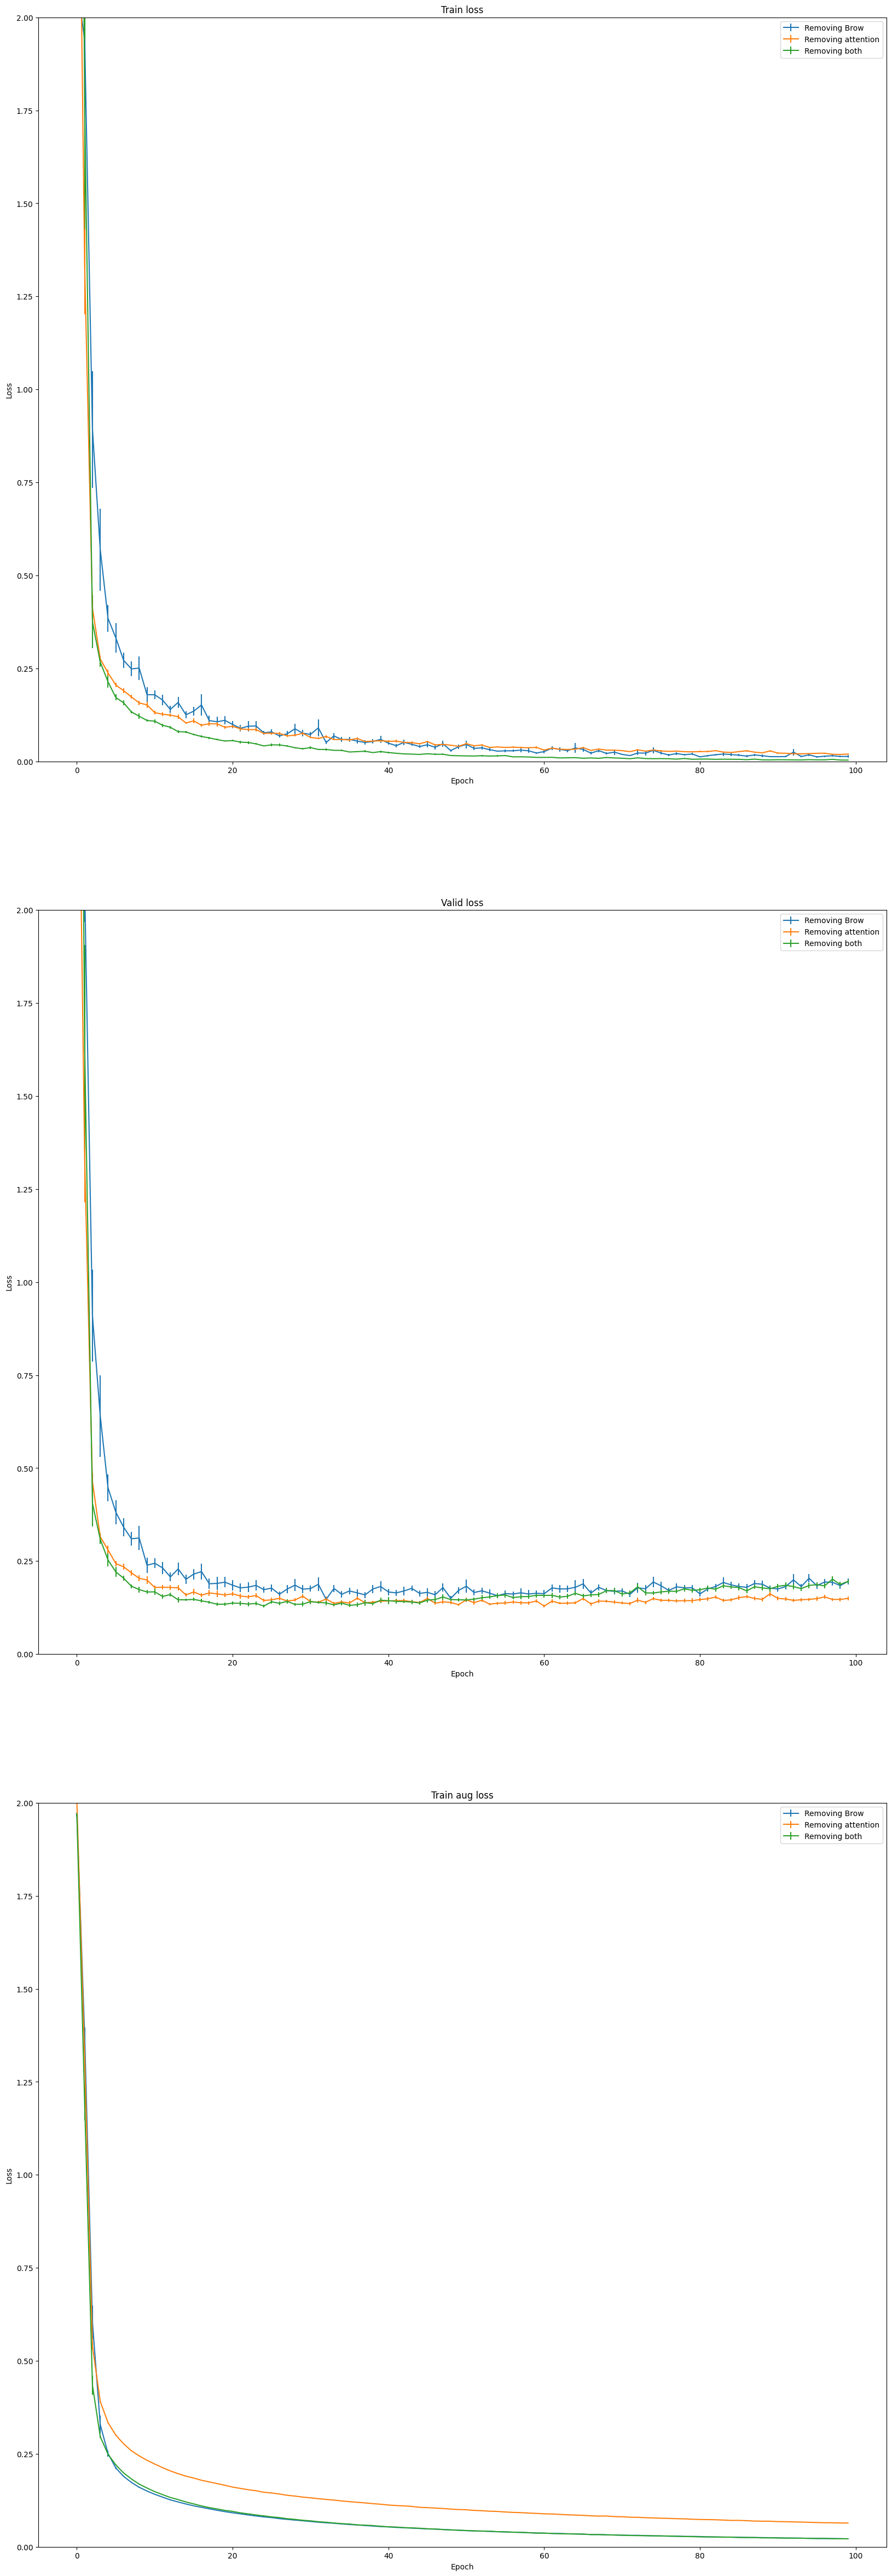

In [6]:
final_remBrow=load_multiple_files(results_newNN_folder,"Ablation",["20240506_14-18-00_FinalRemBrow_log.txt", "20240506_14-46-11_FinalRemBrow_log.txt"])
final_remAtt=load_multiple_files(results_newNN_folder,"Ablation",["20240506_14-07-55_FinalRemAtt_log.txt", "20240506_14-14-01_FinalRemAtt_log.txt"])

final_remAll=load_multiple_files(results_newNN_folder,"Ablation",["20240506_16-21-58_FinalRemAll_log.txt","20240506_17-18-05_FinalRemAll_log.txt"])


compare_dfs([final_remBrow,final_remAtt,final_remAll],["Removing Brow","Removing attention","Removing both"])